In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re
import math
import seaborn as sns
from matplotlib import pyplot as plt
from collections import defaultdict
from IPython.core.display import display, HTML
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
#display(HTML(my_html))     # make sure Jupyter knows to display it as HTML

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

In [2]:
dirs = {'fassbinder': 'https://www.imdb.com/name/nm0001202/', \
        'godard':'https://www.imdb.com/name/nm0000419/', \
        'hitchcock': 'https://www.imdb.com/name/nm0000033', \
        'spielberg': 'https://www.imdb.com/name/nm0000229', \
        'kurosawa': 'https://www.imdb.com/name/nm0000041/', \
        'bergman': 'https://www.imdb.com/name/nm0000005/', \
        'allen': 'https://www.imdb.com/name/nm0000095',\
        'herzog': 'https://www.imdb.com/name/nm0001348/'}
        # scorcese

dirs_box_office = {'godard':'https://www.the-numbers.com/person/55430401-Jean-Luc-Godard#tab=technical', \
                   'hitchcock':'https://www.the-numbers.com/person/66230401-Alfred-Hitchcock#tab=technical', \
                   'spielberg': 'https://www.the-numbers.com/person/135430401-Steven-Spielberg#tab=technical',\
                   'allen':'https://www.the-numbers.com/person/4010401-Woody-Allen#tab=technical', \
                   'bergman': 'https://www.the-numbers.com/person/13600401-Ingmar-Bergman#tab=technical',\
                   'herzog':'https://www.the-numbers.com/person/65080401-Werner-Herzog#tab=technical'}

In [3]:
director = 'godard'

In [4]:

dirs_page = dirs[director]
url = dirs_page
response = requests.get(url)
print( response.status_code )
page = response.text
soup = BeautifulSoup(page, "lxml")
#need to distinguish 'filmo-head-director' from 'assistant_director' etc.
head_director_soup = soup.find('div', id='filmo-head-director')
head_director_section_soup= head_director_soup.find_next_sibling('div', class_='filmo-category-section')
films = head_director_section_soup.find_all('div', class_=re.compile('filmo-row'), id=re.compile("director"))
#films = soup.find_all('div', class_=re.compile('filmo-row'), id=re.compile("director"))

200


* Clean the datapoints below
* Ensure they are available or handled for each film's page
* Convert into numeric datatypes
* Populate a list of dictionaries with these 
* Within the loop that goes through every flick, populate the list of dictionaries with these
* Do one-hot-encoding on categorical variables
* Train and test the linear regression model

In [5]:
def is_tv_series( the_film_soup ):
    try:
        parenthesis = the_film_soup.find('a').next
        try:
            if 'TV ' in parenthesis.next:
                return True
            else:
                return False
        except:
            return False
    except:
        return False

In [6]:
def is_documentary( the_film_soup ):
    try:
        parenthesis = the_film_soup.find('a').next
        #print(parenthesis)
        try:
            if 'documentary' in parenthesis.next.lower():
                return 1
            else:
                return 0
        except:
            return 0
    except:
        return 0

In [7]:
def parse_crew_data(the_crew_soup):
    crew_data = {}
    try: 
        #print( the_crew_soup.find('h4', id='cinematographer').next_sibling )
        crew_data['cinematographer'] = the_crew_soup.find('h4', id='cinematographer').find_next_sibling('table', class_='simpleTable').find('a').text.strip()
    except: 
        crew_data['cinematographer'] = ''
    return (crew_data)

In [8]:
def parse_cast_data(the_film_soup):
    try:
        cast_table = the_film_soup.find('table', class_='cast_list').find_all('td', class_='primary_photo')
        cast_list = [(row.find_next_sibling().text.strip(), 1) for row in cast_table ]
        #cast_dict= defaultdict(cast_list)
        #cast_dict.setdefault(1)
        cast_dict = dict(cast_list)
        #print(cast_dict)
        return(cast_dict)
        #return(  the_film_soup.find('table', class_='cast_list').find_all('a', class_='primary_photo').find_next_sibling().text )
        
  #     the_film_soup.find('table', class_='cast_list').find_all('a', class_=re.compile('filmo-row'), id=re.compile("director"))
  #  return the_film_soup.find('table', class_='cast_list').find('a')
    except:
        return dict()

In [9]:
#crew_url = test_url + '/fullcredits'
crew_url = 'https://www.imdb.com/title/tt0084654/fullcredits'
crew_response = requests.get(crew_url)
crew_page = crew_response.text
crew_soup = BeautifulSoup(crew_page, "lxml")

the_crew_data = parse_crew_data( crew_soup )
#print(the_crew_data)
#print(is_tv_series(test_row))

In [10]:
def get_film_data_only_title( film_soup ):
    film_title_string = film_soup.find(class_ = 'title_wrapper').find('h1').text
    print(film_title_string)
    
# searching from the page_content might be more efficient. To be tested later
def parse_film_data( film_soup ):
    film_data = {}
    
    try:        
        film_title_string = (film_soup.find(class_ = 'title_wrapper').find('h1').text).strip()
    except:
        film_title_string = ''
    title_line = film_title_string.split('\xa0(')
    film_data['title'] = title_line[0].replace('\xa0','').rstrip() # title part of title line
    
    film_data['year'] = title_line[1].replace(') ', '').strip(')') if len(title_line) > 1 else '' # year part of title line
    
    try:
        film_rating_tag = film_soup.find('span', itemprop='ratingValue')
        try:
            film_rating_string = film_rating_tag.text   #find_next_sibling().text
        except:
            film_rating_string = None      
    except:
        film_rating_string = None 
    film_data['rating'] = film_rating_string
   
    try:
        film_rating_count_tag = film_soup.find('span', itemprop='ratingCount')
        try:
            film_rating_count = float( film_rating_count_tag.text.replace(',', '')) #find_next_sibling().text
        except:
            film_rating_count = None 
    except:
            film_rating_count = None 
    film_data['rating_count'] = film_rating_count
    
    try:
        film_duration_string = film_soup.find('time').text
        dur_list = film_duration_string.replace('min','').rstrip().split('h ')
        film_data['duration'] = (int(dur_list[-1]) + 60*int(dur_list[0])) if (len(dur_list)>1) else int(dur_list[-1])
    except:
        film_data['duration'] = None
      
    try:
        film_date_string = film_soup.find('a', title='see more release dates')
    except:
        film_date_string = ''  
    
    try:
        film_release_date_tag = film_soup.find('h4', text=re.compile('Release Date:'))
        try:
            film_release_date = film_release_date_tag.next_sibling.replace('\n', '')
        except:
            film_release_date = '' 
    except:
            film_release_date = '' 
    film_data['release_date'] = film_release_date
    
    
    try:
        film_metacritic_score_tag = film_soup.find('div', class_=re.compile('metacriticScore'))
        try:
            film_metacritic_score = film_metacritic_score_tag.find('span').text
        except:
            film_metacritic_score = None #math.nan  
    except:
        film_metacritic_score = None #math.nan  
    film_data['metacritic_score'] = film_metacritic_score
    try:
        film_details = film_soup.find('div', class_='article', id='titleDetails')
        try:        
            film_gross_string = film_details.find('h4', text=re.compile('Cumulative Worldwide Gross:')).next_sibling
            film_gross = int( re.sub("[^0-9]", "", film_gross_string ))
        except:
             film_gross = None 
    except:
        film_gross = None 
    film_data['worldwide_gross_imdb']  = film_gross
    
    try:
        film_runtime_tag = film_soup.find('h4', text=re.compile('Runtime:'))
        try:
             film_runtime = int(film_runtime_tag.find_next_sibling().text.strip(' min'))
        except:
            film_runtime = None 
    except:
            film_runtime = None
    film_data['runtime'] = film_runtime
    try:
        film_budget_tag = film_soup.find('h4', text=re.compile('Budget'))
        try:
            film_budget = int( re.sub("[^0-9]", "", film_budget_tag.next_sibling ))
        except:
            film_budget = None #math.nan  
    except:
            film_budget = None #math.nan  
    film_data['budget'] = film_budget
      
    return film_data

In [11]:
list_of_films = []
dict_of_all_actors = {}

index_ = 0 # temporary for record keeping
for film in films:
    cast_dict = {}
    if ( not is_tv_series(film)): 
        film_url_suffix = film.find('a').get('href')
        film_url = 'https://imdb.com' + film_url_suffix
        print('\n', film_url)
        film_response = requests.get(film_url)
        if(film_response.status_code < 400):
            film_page = film_response.text
            film_soup = BeautifulSoup(film_page, "lxml")
            film_record = parse_film_data( film_soup )
            film_record['tv_series'] = 0
    else:  # To be customized 
        film_url_suffix = film.find('a').get('href')
        film_url = 'https://imdb.com' + film_url_suffix
        print('\n', film_url)
        film_response = requests.get(film_url)
        if(film_response.status_code < 400):
            film_page = film_response.text
            film_soup = BeautifulSoup(film_page, "lxml")
            film_record = parse_film_data( film_soup )
            film_record['tv_series'] = 1
            
    film_record['documentary'] = is_documentary(film)
    #print(film_record)
    
    crew_url = film_url + 'fullcredits'
   # print(crew_url)
    crew_response = requests.get(crew_url)
    crew_page = crew_response.text
    crew_soup = BeautifulSoup(crew_page, "lxml")
    film_record.update( parse_crew_data(crew_soup) )
    cast_dict = parse_cast_data(film_soup)
    film_record.update( cast_dict )
    dict_of_all_actors.update( cast_dict )
    #dict_of_all_actors = parse_cast_data(film_soup)
   
    print(index_) # temporary for record keeping
    print(film_record)
    
    list_of_films.append(film_record)
    index_+=1
    
film_catalog = pd.DataFrame(list_of_films )


 https://imdb.com/title/tt12089010/
0
{'title': 'Spot of the 22nd Ji.hlava IDFF', 'year': '2018', 'rating': '7.2', 'rating_count': 20.0, 'duration': 1, 'release_date': '', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 1, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': '', 'Jean-Luc Godard': 1}

 https://imdb.com/title/tt5749596/
1
{'title': 'The Image Book', 'year': '2018', 'rating': '6.2', 'rating_count': 2314.0, 'duration': 84, 'release_date': ' 25 January 2019 (USA)    ', 'metacritic_score': '76', 'worldwide_gross_imdb': 132015, 'runtime': 84, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Fabrice Aragno', 'Jean-Luc Godard': 1, 'Dimitri Basil': 1, 'Jean-Pierre Gos': 1, 'Anne-Marie Miéville': 1, 'Jacques Perconte': 1}

 https://imdb.com/title/tt8362750/
2
{'title': "Bande-annonce de 'Le livre d'image'", 'year': '2018', 'rating': '7.2', 'rating_count': 23.0, 'duration': 2, 'release_date': ' 27 April 2018 (France)    ', 

19
{'title': 'Ten Minutes Older: The Cello', 'year': '2002', 'rating': '6.7', 'rating_count': 1663.0, 'duration': 146, 'release_date': ' 26 June 2003 (Germany)    ', 'metacritic_score': None, 'worldwide_gross_imdb': 14378, 'runtime': 95, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Ali Asad', 'Valeria Bruni Tedeschi': 1, 'Amit Rayani': 1, 'Tarun Bedi': 1, 'Maria Ludovica Bernardi': 1, 'Chiara Mastalli': 1, 'Jabedul Azad': 1, 'Zohirul Azad': 1, 'Mark Long': 1, 'Alexandra Staden': 1, 'Dominic West': 1, 'Howard Goorney': 1, 'Maria Charles': 1, 'Daniel Tookey': 1, 'George Keane': 1, 'Rudolf Hrusínský': 1}

 https://imdb.com/title/tt0385051/
20
{'title': 'Liberté et patrie', 'year': '2002', 'rating': '6.6', 'rating_count': 171.0, 'duration': 21, 'release_date': ' August 2002 (Switzerland)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 21, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': '', 'Jean-Pierre Gos': 1, 'Geneviè

35
{'title': 'Les enfants jouent à la Russie', 'year': '1993', 'rating': '6.0', 'rating_count': 131.0, 'duration': None, 'release_date': ' 8 August 1993 (Switzerland)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 60, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Caroline Champetier', 'László Szabó': 1, 'Jean-Luc Godard': 1, 'Bernard Eisenschitz': 1, 'André S. Labarthe': 1, 'Aude Amiot': 1, 'Irina Apeksimova': 1, 'Marie Borowski': 1, 'Benjamin Kraatz': 1, 'Bénédicte Loyen': 1}

 https://imdb.com/title/tt2698170/
36
{'title': "L'enfance de l'art", 'year': '1992', 'rating': '6.5', 'rating_count': 27.0, 'duration': 7, 'release_date': ' 1992 (France)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 7, 'budget': 20000, 'tv_series': 0, 'documentary': 0, 'cinematographer': '', 'Antoine Reyes': 1}

 https://imdb.com/title/tt3304856/
37
{'title': 'Parisienne People Cigarettes', 'year': '1992', 'rating': '4.8', 'rating_cou

53
{'title': 'King Lear', 'year': '1987', 'rating': '5.6', 'rating_count': 1204.0, 'duration': 90, 'release_date': ' 3 April 2002 (France)    ', 'metacritic_score': None, 'worldwide_gross_imdb': 85018, 'runtime': 90, 'budget': 2000000, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Sophie Maintigneux', 'Woody Allen': 1, 'Freddy Buache': 1, 'Leos Carax': 1, 'Julie Delpy': 1, 'Jean-Luc Godard': 1, 'Suzanne Lanza': 1, 'Kate Mailer': 1, 'Norman Mailer': 1, 'Burgess Meredith': 1, 'Michèle Pétin': 1, 'Molly Ringwald': 1, 'Peter Sellars': 1}

 https://imdb.com/title/tt0091504/
54
{'title': 'Meeting Woody Allen', 'year': '1986', 'rating': '6.9', 'rating_count': 920.0, 'duration': 26, 'release_date': ' 1986 (France)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 26, 'budget': None, 'tv_series': 0, 'documentary': 1, 'cinematographer': 'Pierre Binggeli', 'Woody Allen': 1, 'Jean-Luc Godard': 1, 'Annette Insdorf': 1}

 https://imdb.com/title/tt0167732/
55
{'title': 

67
{'title': 'Sauve la vie (qui peut)', 'year': '1981', 'rating': '6.3', 'rating_count': 63.0, 'duration': 102, 'release_date': '', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 102, 'budget': None, 'tv_series': 0, 'documentary': 1, 'cinematographer': ''}

 https://imdb.com/title/tt3305340/
68
{'title': 'Une bonne à tout faire', 'year': '1981', 'rating': '7.0', 'rating_count': 29.0, 'duration': 8, 'release_date': ' 1981 (France)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 8, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': '', 'Jerzy Radziwilowicz': 1}

 https://imdb.com/title/tt5235808/
69
{'title': "Bande-annonce de 'Sauve qui peut (la vie)'", 'year': '1980', 'rating': '6.4', 'rating_count': 12.0, 'duration': 3, 'release_date': '', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 3, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': '', 'Nathalie Baye': 1, 'Jacques Dutronc': 1, '

86
{'title': 'Pravda', 'year': '1970', 'rating': '5.5', 'rating_count': 231.0, 'duration': 58, 'release_date': ' 21 May 1970 (USA)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 58, 'budget': None, 'tv_series': 0, 'documentary': 1, 'cinematographer': '', 'Vera Chytilová': 1, 'Jean-Luc Godard': 1}

 https://imdb.com/title/tt0065494/
87
{'title': 'See You at Mao', 'year': '1970', 'rating': '6.1', 'rating_count': 453.0, 'duration': 54, 'release_date': ' 21 May 1970 (USA)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 52, 'budget': None, 'tv_series': 0, 'documentary': 1, 'cinematographer': 'Charles Stewart'}

 https://imdb.com/title/tt0062997/
88
{'title': 'Le Gai Savoir', 'year': '1969', 'rating': '6.2', 'rating_count': 868.0, 'duration': 95, 'release_date': ' 12 July 1969 (UK)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': None, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Georges Lecle

105
{'title': "Bande-annonce de 'Pierrot le fou'", 'year': '1965', 'rating': '6.8', 'rating_count': 29.0, 'duration': 2, 'release_date': '', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 2, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': '', 'Jean-Paul Belmondo': 1, 'Anna Karina': 1}

 https://imdb.com/title/tt0059592/
106
{'title': 'Pierrot le Fou', 'year': '1965', 'rating': '7.6', 'rating_count': 29534.0, 'duration': 110, 'release_date': ' 8 January 1969 (USA)    ', 'metacritic_score': None, 'worldwide_gross_imdb': 134722, 'runtime': 110, 'budget': 300000, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Raoul Coutard', 'Jean-Paul Belmondo': 1, 'Anna Karina': 1, 'Graziella Galvani': 1}

 https://imdb.com/title/tt0059565/
107
{'title': 'Paris vu par...', 'year': '1965', 'rating': '6.8', 'rating_count': 992.0, 'duration': 95, 'release_date': ' 19 May 1965 (France)    ', 'metacritic_score': None, 'worldwide_gross_imdb': 15532, 'runtime': 95

122
{'title': 'A Woman Is a Woman', 'year': '1961', 'rating': '7.5', 'rating_count': 15492.0, 'duration': 84, 'release_date': ' 6 September 1961 (France)    ', 'metacritic_score': '71', 'worldwide_gross_imdb': 100665, 'runtime': 85, 'budget': 160000, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Raoul Coutard', 'Jean-Claude Brialy': 1, 'Anna Karina': 1, 'Jean-Paul Belmondo': 1}

 https://imdb.com/title/tt0052338/
123
{'title': "Une histoire d'eau", 'year': '1961', 'rating': '6.7', 'rating_count': 1341.0, 'duration': 12, 'release_date': ' 19 March 1994 (Japan)    ', 'metacritic_score': None, 'worldwide_gross_imdb': None, 'runtime': 12, 'budget': None, 'tv_series': 0, 'documentary': 0, 'cinematographer': 'Michel Latouche', 'Jean-Claude Brialy': 1, 'Caroline Dim': 1, 'Jean-Luc Godard': 1}

 https://imdb.com/title/tt0051472/
124
{'title': 'Charlotte et son Jules', 'year': '1960', 'rating': '6.6', 'rating_count': 1439.0, 'duration': 20, 'release_date': ' 3 March 1961 (France)    ', 

In [12]:
film_catalog['year'] = pd.to_numeric(film_catalog['year'])
film_catalog['rating'] = pd.to_numeric(film_catalog['rating'])
film_catalog['worldwide_gross_imdb'] = pd.to_numeric(film_catalog['worldwide_gross_imdb'])
film_catalog['budget'] = pd.to_numeric(film_catalog['budget'])
film_catalog['metacritic_score'] = pd.to_numeric(film_catalog['metacritic_score'])

In [13]:
len(film_catalog.columns)

744

In [14]:
len(dict_of_all_actors)

731

In [15]:
len(film_catalog.columns) - len(dict_of_all_actors)

13

In [16]:
first_cast_column = len(film_catalog.columns) - len(dict_of_all_actors)
first_cast_column

13

In [17]:
main_column_names = list(film_catalog.columns[:first_cast_column])
main_column_names 

['title',
 'year',
 'rating',
 'rating_count',
 'duration',
 'release_date',
 'metacritic_score',
 'worldwide_gross_imdb',
 'runtime',
 'budget',
 'tv_series',
 'documentary',
 'cinematographer']

In [18]:
film_catalog.iloc[:,first_cast_column:] # temporary, to check work

,Jean-Luc Godard,Dimitri Basil,Jean-Pierre Gos,Anne-Marie Miéville,Jacques Perconte,Bogdan Ninkovic,Fedja Stamenkovic,Andrej Ivancic,Nikola Brkovic,Mihailo Kovic,...,Liliane Dreyfus,Michel Fabre,Jean-Pierre Melville,Richard Balducci,François Moreuil,Jacques Lourcelles,Nicole Berger,Maria Lysandre,Roland Tolmatchoff,Carmen Mirando
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
127,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
import copy
df_actors = copy.deepcopy(film_catalog.iloc[:, first_cast_column:])
df_actors

,Jean-Luc Godard,Dimitri Basil,Jean-Pierre Gos,Anne-Marie Miéville,Jacques Perconte,Bogdan Ninkovic,Fedja Stamenkovic,Andrej Ivancic,Nikola Brkovic,Mihailo Kovic,...,Liliane Dreyfus,Michel Fabre,Jean-Pierre Melville,Richard Balducci,François Moreuil,Jacques Lourcelles,Nicole Berger,Maria Lysandre,Roland Tolmatchoff,Carmen Mirando
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
127,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
df_actors.sum().sort_values(ascending = False)

Jean-Luc Godard        38.0
Anna Karina            11.0
Anne-Marie Miéville    10.0
Anne Wiazemsky          7.0
Jean-Pierre Léaud       7.0
                       ... 
Uwe Grzechowski         1.0
Jochen Gliscinsky       1.0
Iva Svarcová            1.0
Elfi Gäbel              1.0
Carmen Mirando          1.0
Length: 731, dtype: float64

In [21]:
df_actors_reordered = df_actors[df_actors.sum().sort_values(ascending = False).index]
df_actors_reordered

,Jean-Luc Godard,Anna Karina,Anne-Marie Miéville,Anne Wiazemsky,Jean-Pierre Léaud,László Szabó,Jean-Claude Brialy,Jean-Paul Belmondo,André S. Labarthe,Juliet Berto,...,Kim Kashkashian,Anton Mossine,Heinz Przbylski,Kerstin Boos,H.J. Jurgen,Uwe Grzechowski,Jochen Gliscinsky,Iva Svarcová,Elfi Gäbel,Carmen Mirando
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df_trunk = copy.deepcopy(film_catalog .iloc[:, :first_cast_column])
df_trunk

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,tv_series,documentary,cinematographer
0,Spot of the 22nd Ji.hlava IDFF,2018.0,7.2,20.0,1.0,,NaN,NaN,1.0,NaN,0,0,
1,The Image Book,2018.0,6.2,2314.0,84.0,25 January 2019 (USA),76.0,132015.0,84.0,NaN,0,0,Fabrice Aragno
2,Bande-annonce de 'Le livre d'image',2018.0,7.2,23.0,2.0,27 April 2018 (France),NaN,NaN,2.0,NaN,0,0,
3,Remerciements de Jean-Luc Godard à son Prix d'...,2015.0,5.9,80.0,5.0,13 March 2015 (Switzerland),NaN,NaN,5.0,NaN,0,0,
4,Ponts de Sarajevo,2014.0,5.8,319.0,114.0,16 July 2014 (France),NaN,NaN,114.0,2100000.0,0,0,Julian Atanassov
...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,Charlotte et son Jules,1960.0,6.6,1439.0,20.0,3 March 1961 (France),NaN,NaN,13.0,NaN,0,0,Michel Latouche
125,Breathless,1960.0,7.8,73103.0,90.0,7 February 1961 (USA),NaN,380228.0,90.0,400000.0,0,0,Raoul Coutard
126,"Charlotte et Véronique, ou Tous les garçons s'...",1959.0,7.1,2176.0,21.0,6 May 1959 (France),NaN,NaN,21.0,NaN,0,0,Michel Latouche
127,Opération 'Béton',1958.0,5.2,220.0,20.0,2 July 1958 (France),NaN,NaN,20.0,NaN,0,1,Adrien Porchet


In [23]:
film_catalog_cast_columns_reordered = pd.concat( [df_trunk, df_actors_reordered], axis=1)
film_catalog_cast_columns_reordered

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,...,Kim Kashkashian,Anton Mossine,Heinz Przbylski,Kerstin Boos,H.J. Jurgen,Uwe Grzechowski,Jochen Gliscinsky,Iva Svarcová,Elfi Gäbel,Carmen Mirando
0,Spot of the 22nd Ji.hlava IDFF,2018.0,7.2,20.0,1.0,,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,The Image Book,2018.0,6.2,2314.0,84.0,25 January 2019 (USA),76.0,132015.0,84.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bande-annonce de 'Le livre d'image',2018.0,7.2,23.0,2.0,27 April 2018 (France),NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Remerciements de Jean-Luc Godard à son Prix d'...,2015.0,5.9,80.0,5.0,13 March 2015 (Switzerland),NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ponts de Sarajevo,2014.0,5.8,319.0,114.0,16 July 2014 (France),NaN,NaN,114.0,2100000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,Charlotte et son Jules,1960.0,6.6,1439.0,20.0,3 March 1961 (France),NaN,NaN,13.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125,Breathless,1960.0,7.8,73103.0,90.0,7 February 1961 (USA),NaN,380228.0,90.0,400000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126,"Charlotte et Véronique, ou Tous les garçons s'...",1959.0,7.1,2176.0,21.0,6 May 1959 (France),NaN,NaN,21.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,Opération 'Béton',1958.0,5.2,220.0,20.0,2 July 1958 (France),NaN,NaN,20.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
film_catalog_cast_columns_reordered.iloc[:, :15].head(50)

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,tv_series,documentary,cinematographer,Jean-Luc Godard,Anna Karina
0,Spot of the 22nd Ji.hlava IDFF,2018.0,7.2,20.0,1.0,,NaN,NaN,1.0,NaN,0,0,,1.0,NaN
1,The Image Book,2018.0,6.2,2314.0,84.0,25 January 2019 (USA),76.0,132015.0,84.0,NaN,0,0,Fabrice Aragno,1.0,NaN
2,Bande-annonce de 'Le livre d'image',2018.0,7.2,23.0,2.0,27 April 2018 (France),NaN,NaN,2.0,NaN,0,0,,NaN,NaN
3,Remerciements de Jean-Luc Godard à son Prix d'...,2015.0,5.9,80.0,5.0,13 March 2015 (Switzerland),NaN,NaN,5.0,NaN,0,0,,1.0,NaN
4,Ponts de Sarajevo,2014.0,5.8,319.0,114.0,16 July 2014 (France),NaN,NaN,114.0,2100000.0,0,0,Julian Atanassov,NaN,NaN
5,Goodbye to Language,2014.0,5.9,5487.0,70.0,28 May 2014 (France),75.0,566423.0,70.0,NaN,0,0,Fabrice Aragno,NaN,NaN
6,Khan Khanne,2014.0,7.0,84.0,9.0,May 2014 (France),NaN,NaN,9.0,NaN,0,0,Jean-Luc Godard,1.0,NaN
7,3x3D,2013.0,5.8,313.0,70.0,30 April 2014 (France),NaN,NaN,70.0,NaN,0,0,Luís Branquinho,NaN,NaN
8,Film socialisme,2010.0,5.7,2539.0,102.0,19 May 2010 (France),64.0,222079.0,102.0,NaN,0,0,Fabrice Aragno,NaN,NaN
9,Tribute to Éric Rohmer,2010.0,6.4,110.0,3.0,8 February 2010 (France),NaN,NaN,3.0,NaN,0,0,,1.0,NaN


In [25]:
def get_box_office( the_box_office_url):
    response = requests.get(the_box_office_url)
    print( response.status_code )
    box_office_page = response.text
    box_office_soup = BeautifulSoup(box_office_page, "lxml")
    
    box_office_chart = box_office_soup.find('div', id='technical').find('div', id='page_filling_chart')
    box_office_chart_body = box_office_chart.find('table', id='all_technical_credits').find('tbody')
    box_office_chart_body
    box_office_rows = box_office_chart_body.find_all('tr')

    flix_box_office = []
    for row in box_office_rows:
        try:
            title_data = row.find('td').find_next_sibling('td')
            title=(title_data.find('a').text).strip()
        except:
            title=''
        try:
            worldwide_box_office = title_data.find_next_sibling('td').find_next_sibling().find_next_sibling().find_next_sibling().text   
            worldwide_box_office = int( re.sub("[^0-9]", "", worldwide_box_office ))
            flix_box_office.append({'title': title, 'worldwide_gross_bo': float(worldwide_box_office)})
        except:
            flix_box_office.append({'title': title, 'worldwide_gross_bo':''})
    return(pd.DataFrame(flix_box_office))

In [26]:
box_office_df = get_box_office(dirs_box_office[director])

200


In [27]:
film_catalog_cast_columns_reordered.iloc[:, 10:30].head(50)

,tv_series,documentary,cinematographer,Jean-Luc Godard,Anna Karina,Anne-Marie Miéville,Anne Wiazemsky,Jean-Pierre Léaud,László Szabó,Jean-Claude Brialy,Jean-Paul Belmondo,André S. Labarthe,Juliet Berto,Michel Piccoli,Isabelle Huppert,Jean-Pierre Gos,Nathalie Baye,Myriem Roussel,Jean-Pierre Cassel,Georges Staquet
0,0,0,,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,Fabrice Aragno,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2,0,0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,Julian Atanassov,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,0,Fabrice Aragno,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,0,Jean-Luc Godard,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0,0,Luís Branquinho,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,0,Fabrice Aragno,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0,0,,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
first_cast_column = len(film_catalog.columns) - len(dict_of_all_actors)
first_cast_column

13

In [29]:
#director='hitchcock'
pickled_film_catalog_filename = 'film_catalog_' + director +'.pickle'
pickled_box_office_filename = 'box_office_' + director +'.pickle'
pickled_fc_columns_filename = 'fc_cols_' + director +'.pickle'
pickled_dict_of_actors_filename = 'dict_of_actors_' + director +'.pickle'

In [30]:
#pickled_film_catalog_filename = 'film_catalog_' + director +'.pickle'
with open(pickled_film_catalog_filename, 'wb') as to_write:
    pickle.dump(film_catalog_cast_columns_reordered, to_write)

In [31]:

with open(pickled_box_office_filename, 'wb') as to_write:
    pickle.dump(box_office_df, to_write)

In [32]:
# film_catalog.columns
with open(pickled_fc_columns_filename, 'wb') as to_write:
    pickle.dump(film_catalog.columns, to_write)

In [33]:
# dict_of_all_actors
with open(pickled_dict_of_actors_filename, 'wb') as to_write:
    pickle.dump(dict_of_all_actors, to_write)

## Retrieve scraped data via pickle

In [34]:
pickled_film_catalog_filename = 'film_catalog_' + director +'.pickle'
pickled_box_office_filename = 'box_office_' + director +'.pickle'
pickled_misc_vars_filename = 'misc_vars_' + director +'.pickle'

In [35]:
with open(pickled_film_catalog_filename, 'rb') as read_file:
    film_catalog_cast_columns_reordered = pickle.load(read_file)

In [36]:
with open(pickled_box_office_filename, 'rb') as read_file:
    box_office_df = pickle.load(read_file)

In [37]:
with open(pickled_fc_columns_filename, 'rb') as read_file:
    film_catalog_columns = pickle.load(read_file)


In [38]:
with open(pickled_dict_of_actors_filename, 'rb') as read_file:
    dict_of_all_actors  = pickle.load(read_file) 

In [39]:
first_cast_column = len(film_catalog_columns) - len(dict_of_all_actors)

### Merging, cleaning, wrangling

In [40]:
films_df = pd.merge(film_catalog_cast_columns_reordered, box_office_df, how='outer', left_on='title', right_on='title')

In [41]:
films_df.head(10)

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,...,Anton Mossine,Heinz Przbylski,Kerstin Boos,H.J. Jurgen,Uwe Grzechowski,Jochen Gliscinsky,Iva Svarcová,Elfi Gäbel,Carmen Mirando,worldwide_gross_bo
0,Spot of the 22nd Ji.hlava IDFF,2018.0,7.2,20.0,1.0,,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,The Image Book,2018.0,6.2,2314.0,84.0,25 January 2019 (USA),76.0,132015.0,84.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bande-annonce de 'Le livre d'image',2018.0,7.2,23.0,2.0,27 April 2018 (France),NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Remerciements de Jean-Luc Godard à son Prix d'...,2015.0,5.9,80.0,5.0,13 March 2015 (Switzerland),NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ponts de Sarajevo,2014.0,5.8,319.0,114.0,16 July 2014 (France),NaN,NaN,114.0,2100000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Goodbye to Language,2014.0,5.9,5487.0,70.0,28 May 2014 (France),75.0,566423.0,70.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Khan Khanne,2014.0,7.0,84.0,9.0,May 2014 (France),NaN,NaN,9.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3x3D,2013.0,5.8,313.0,70.0,30 April 2014 (France),NaN,NaN,70.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Film socialisme,2010.0,5.7,2539.0,102.0,19 May 2010 (France),64.0,222079.0,102.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Tribute to Éric Rohmer,2010.0,6.4,110.0,3.0,8 February 2010 (France),NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
films_df.head()

,title,year,rating,rating_count,duration,release_date,metacritic_score,worldwide_gross_imdb,runtime,budget,...,Anton Mossine,Heinz Przbylski,Kerstin Boos,H.J. Jurgen,Uwe Grzechowski,Jochen Gliscinsky,Iva Svarcová,Elfi Gäbel,Carmen Mirando,worldwide_gross_bo
0,Spot of the 22nd Ji.hlava IDFF,2018.0,7.2,20.0,1.0,,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,The Image Book,2018.0,6.2,2314.0,84.0,25 January 2019 (USA),76.0,132015.0,84.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bande-annonce de 'Le livre d'image',2018.0,7.2,23.0,2.0,27 April 2018 (France),NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Remerciements de Jean-Luc Godard à son Prix d'...,2015.0,5.9,80.0,5.0,13 March 2015 (Switzerland),NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ponts de Sarajevo,2014.0,5.8,319.0,114.0,16 July 2014 (France),NaN,NaN,114.0,2100000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
# these renamings are temporary
if('box_office' in films_df.columns):
    films_df.rename(columns={'box_office':'worldwide_gross_bo'}, inplace=True)
    films_df

In [44]:
# these renamings are temporary
if('worldwide_gross' in films_df.columns):
    films_df.rename(columns={'worldwide_gross':'worldwide_gross_imdb'}, inplace=True)

In [45]:
main_column_names_rearranged = ['title', 'year', 'release_date', 'duration', 'runtime', 'budget', 'worldwide_gross_imdb', 'worldwide_gross_bo', 'rating', 'metacritic_score', 'rating_count', 'tv_series', 'documentary','cinematographer']
cast_column_names= films_df.columns[first_cast_column:-1]

In [46]:
films_df.columns[:15]

Index(['title', 'year', 'rating', 'rating_count', 'duration', 'release_date',
       'metacritic_score', 'worldwide_gross_imdb', 'runtime', 'budget',
       'tv_series', 'documentary', 'cinematographer', 'Jean-Luc Godard',
       'Anna Karina'],
      dtype='object')

In [47]:
import copy


films_df_reordered=copy.deepcopy(films_df[[*main_column_names_rearranged, *cast_column_names] ] )                         
                            

In [48]:
films_df_reordered.head(10)

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,...,Kim Kashkashian,Anton Mossine,Heinz Przbylski,Kerstin Boos,H.J. Jurgen,Uwe Grzechowski,Jochen Gliscinsky,Iva Svarcová,Elfi Gäbel,Carmen Mirando
0,Spot of the 22nd Ji.hlava IDFF,2018.0,,1.0,1.0,NaN,NaN,NaN,7.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,The Image Book,2018.0,25 January 2019 (USA),84.0,84.0,NaN,132015.0,NaN,6.2,76.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bande-annonce de 'Le livre d'image',2018.0,27 April 2018 (France),2.0,2.0,NaN,NaN,NaN,7.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Remerciements de Jean-Luc Godard à son Prix d'...,2015.0,13 March 2015 (Switzerland),5.0,5.0,NaN,NaN,NaN,5.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ponts de Sarajevo,2014.0,16 July 2014 (France),114.0,114.0,2100000.0,NaN,NaN,5.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Goodbye to Language,2014.0,28 May 2014 (France),70.0,70.0,NaN,566423.0,NaN,5.9,75.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Khan Khanne,2014.0,May 2014 (France),9.0,9.0,NaN,NaN,NaN,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3x3D,2013.0,30 April 2014 (France),70.0,70.0,NaN,NaN,NaN,5.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Film socialisme,2010.0,19 May 2010 (France),102.0,102.0,NaN,222079.0,NaN,5.7,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Tribute to Éric Rohmer,2010.0,8 February 2010 (France),3.0,3.0,NaN,NaN,NaN,6.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
films_df_reordered.shape

(142, 745)

#### Clean up the `year` column

In [50]:
films_df_reordered['release_date'].fillna('', inplace=True)

In [51]:
films_df_reordered

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,...,Kim Kashkashian,Anton Mossine,Heinz Przbylski,Kerstin Boos,H.J. Jurgen,Uwe Grzechowski,Jochen Gliscinsky,Iva Svarcová,Elfi Gäbel,Carmen Mirando
0,Spot of the 22nd Ji.hlava IDFF,2018.0,,1.0,1.0,NaN,NaN,NaN,7.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,The Image Book,2018.0,25 January 2019 (USA),84.0,84.0,NaN,132015.0,NaN,6.2,76.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bande-annonce de 'Le livre d'image',2018.0,27 April 2018 (France),2.0,2.0,NaN,NaN,NaN,7.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Remerciements de Jean-Luc Godard à son Prix d'...,2015.0,13 March 2015 (Switzerland),5.0,5.0,NaN,NaN,NaN,5.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ponts de Sarajevo,2014.0,16 July 2014 (France),114.0,114.0,2100000.0,NaN,NaN,5.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,PrÃ©nom Carmen,NaN,,NaN,NaN,NaN,NaN,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138,DÃ©tectÃ­ve,NaN,,NaN,NaN,NaN,NaN,,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139,Bande Ã part,NaN,,NaN,NaN,NaN,NaN,222271.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140,Le MÃ©pris,NaN,,NaN,NaN,NaN,NaN,544591.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
flix_to_clean_yr = (np.isnan(films_df_reordered['year'])) & (films_df_reordered['release_date']!='') & (films_df_reordered['release_date']!= 'NaN')

In [53]:
#films_df_reordered.loc[films_df_reordered[flix_to_clean_yr ], 'years'] = films_df_reordered.loc[films_df_reordered[flix_to_clean_yr ], 'years']

In [54]:
# use the release_date column where possible to set missing values in the year column
#films_df_reordered['year']=films_df_reordered.apply(lambda row: float((re.search(r'\d{4}', row['release_date'])).group()) if (np.isnan(row['year']) & (row['release_date']!='') & (row['release_date']!='NaN') ) else row['year'], axis=1)

cleaned_yrs = films_df_reordered.apply(lambda row: float((re.search(r'\d{4}', row['release_date'])).group()) if (np.isnan(row['year']) & (row['release_date']!='') & (row['release_date']!='NaN') ) else row['year'], axis=1)
films_df_reordered.loc[:, 'year'] = cleaned_yrs


In [55]:
films_df_reordered.tail(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,...,Kim Kashkashian,Anton Mossine,Heinz Przbylski,Kerstin Boos,H.J. Jurgen,Uwe Grzechowski,Jochen Gliscinsky,Iva Svarcová,Elfi Gäbel,Carmen Mirando
92,Un film comme les autres,1968.0,29 December 1968 (USA),100.0,120.0,NaN,NaN,NaN,5.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,Sympathy for the Devil,1968.0,22 April 1969 (USA),100.0,100.0,NaN,NaN,NaN,6.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,Bande-annonce de 'Mouchette',1967.0,,2.0,2.0,NaN,NaN,NaN,6.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,Bande-annonce De 'Week End',1967.0,,3.0,3.0,NaN,NaN,NaN,7.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,Weekend,1967.0,27 September 1968 (USA),105.0,105.0,250000.0,NaN,NaN,7.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,Far from Vietnam,1967.0,6 June 1968 (USA),NaN,115.0,NaN,8132.0,NaN,7.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,La Chinoise,1967.0,4 March 1968 (USA),95.0,95.0,NaN,36488.0,NaN,7.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,The Oldest Profession,1967.0,8 November 1968 (USA),119.0,119.0,NaN,NaN,NaN,5.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,2 or 3 Things I Know About Her,1967.0,17 March 1967 (France),87.0,87.0,NaN,104038.0,NaN,6.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,Bande-annonce De 'Made in U.S.A.',1966.0,,2.0,2.0,NaN,NaN,NaN,6.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Clean up the `duration` column

In [56]:
films_df_reordered['duration']=films_df_reordered.apply(lambda row: row['runtime'] if (np.isnan(row['duration']) ) else row['duration'], axis=1)

#### Clean up the `bo_worldwide_gross` column

In [57]:
films_df_reordered['worldwide_gross'] = films_df_reordered.apply(lambda row: float(row['worldwide_gross_bo']) if (pd.notna(row['worldwide_gross_bo'])) & (row['worldwide_gross_bo']!='' ) else row['worldwide_gross_imdb'], axis=1)

In [58]:
films_df_reordered.head(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,...,Anton Mossine,Heinz Przbylski,Kerstin Boos,H.J. Jurgen,Uwe Grzechowski,Jochen Gliscinsky,Iva Svarcová,Elfi Gäbel,Carmen Mirando,worldwide_gross
0,Spot of the 22nd Ji.hlava IDFF,2018.0,,1.0,1.0,NaN,NaN,NaN,7.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,The Image Book,2018.0,25 January 2019 (USA),84.0,84.0,NaN,132015.0,NaN,6.2,76.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132015.0
2,Bande-annonce de 'Le livre d'image',2018.0,27 April 2018 (France),2.0,2.0,NaN,NaN,NaN,7.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Remerciements de Jean-Luc Godard à son Prix d'...,2015.0,13 March 2015 (Switzerland),5.0,5.0,NaN,NaN,NaN,5.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ponts de Sarajevo,2014.0,16 July 2014 (France),114.0,114.0,2100000.0,NaN,NaN,5.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Goodbye to Language,2014.0,28 May 2014 (France),70.0,70.0,NaN,566423.0,NaN,5.9,75.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,566423.0
6,Khan Khanne,2014.0,May 2014 (France),9.0,9.0,NaN,NaN,NaN,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3x3D,2013.0,30 April 2014 (France),70.0,70.0,NaN,NaN,NaN,5.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Film socialisme,2010.0,19 May 2010 (France),102.0,102.0,NaN,222079.0,NaN,5.7,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,222079.0
9,Tribute to Éric Rohmer,2010.0,8 February 2010 (France),3.0,3.0,NaN,NaN,NaN,6.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Remove rows with too many missing values

In [59]:
films_df_reordered.shape

(142, 746)

In [60]:

n=films_df_reordered.iloc[:, :first_cast_column].notna()
n.sum(axis=1).head(50)


0      9
1     11
2      9
3      9
4     10
5     11
6      9
7      9
8     11
9      9
10     9
11     9
12     9
13     9
14     9
15     9
16     9
17    11
18     8
19    10
20     9
21     8
22    11
23     9
24     9
25     9
26    10
27     9
28    10
29     7
30     9
31     7
32     9
33     9
34     9
35     9
36    10
37     9
38     9
39     9
40     8
41     7
42     9
43     8
44     9
45     9
46     9
47     9
48     9
49     9
dtype: int64

In [61]:
first_cast_column

13

In [62]:
thresh=.4
thresh*first_cast_column

5.2

In [63]:
films_df_reordered.loc[n.sum(axis=1) >= thresh*first_cast_column]

,title,year,release_date,duration,runtime,budget,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,...,Anton Mossine,Heinz Przbylski,Kerstin Boos,H.J. Jurgen,Uwe Grzechowski,Jochen Gliscinsky,Iva Svarcová,Elfi Gäbel,Carmen Mirando,worldwide_gross
0,Spot of the 22nd Ji.hlava IDFF,2018.0,,1.0,1.0,NaN,NaN,NaN,7.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,The Image Book,2018.0,25 January 2019 (USA),84.0,84.0,NaN,132015.0,NaN,6.2,76.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132015.0
2,Bande-annonce de 'Le livre d'image',2018.0,27 April 2018 (France),2.0,2.0,NaN,NaN,NaN,7.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Remerciements de Jean-Luc Godard à son Prix d'...,2015.0,13 March 2015 (Switzerland),5.0,5.0,NaN,NaN,NaN,5.9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ponts de Sarajevo,2014.0,16 July 2014 (France),114.0,114.0,2100000.0,NaN,NaN,5.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,Charlotte et son Jules,1960.0,3 March 1961 (France),20.0,13.0,NaN,NaN,NaN,6.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125,Breathless,1960.0,7 February 1961 (USA),90.0,90.0,400000.0,380228.0,NaN,7.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380228.0
126,"Charlotte et Véronique, ou Tous les garçons s'...",1959.0,6 May 1959 (France),21.0,21.0,NaN,NaN,NaN,7.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,Opération 'Béton',1958.0,2 July 1958 (France),20.0,20.0,NaN,NaN,NaN,5.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
films_df_reordered.iloc[70, :].head(30)

title                           Every Man for Himself
year                                           1980.0
release_date             15 October 1980 (France)    
duration                                         87.0
runtime                                           NaN
budget                                            NaN
worldwide_gross_imdb                          47262.0
worldwide_gross_bo                                NaN
rating                                            6.8
metacritic_score                                  NaN
rating_count                                   3010.0
tv_series                                         0.0
documentary                                       0.0
cinematographer                          Renato Berta
Jean-Luc Godard                                   NaN
Anna Karina                                       NaN
Anne-Marie Miéville                               NaN
Anne Wiazemsky                                    NaN
Jean-Pierre Léaud           

In [65]:
films_df_reordered.columns

Index(['title', 'year', 'release_date', 'duration', 'runtime', 'budget',
       'worldwide_gross_imdb', 'worldwide_gross_bo', 'rating',
       'metacritic_score',
       ...
       'Anton Mossine', 'Heinz Przbylski', 'Kerstin Boos', 'H.J. Jurgen',
       'Uwe Grzechowski', 'Jochen Gliscinsky', 'Iva Svarcová', 'Elfi Gäbel',
       'Carmen Mirando', 'worldwide_gross'],
      dtype='object', length=746)

In [66]:


films_df_reordered = films_df_reordered.loc[n.sum(axis=1) >= thresh*first_cast_column, :] 

In [67]:
films_df_reordered.shape

(128, 746)

#### Cleap up the ordering of columns

In [68]:
main_column_names_rearranged = ['title', 'year', 'release_date', 'duration', 'runtime', 'budget', 'worldwide_gross','worldwide_gross_imdb', 'worldwide_gross_bo', 'rating', 'metacritic_score', 'rating_count', 'tv_series', 'documentary','cinematographer']
cast_column_names= films_df.columns[first_cast_column:-1]

In [69]:
films_df_reordered=films_df_reordered[[*main_column_names_rearranged, *cast_column_names] ] 

In [70]:
films_df_reordered.columns[:20]

Index(['title', 'year', 'release_date', 'duration', 'runtime', 'budget',
       'worldwide_gross', 'worldwide_gross_imdb', 'worldwide_gross_bo',
       'rating', 'metacritic_score', 'rating_count', 'tv_series',
       'documentary', 'cinematographer', 'Jean-Luc Godard', 'Anna Karina',
       'Anne-Marie Miéville', 'Anne Wiazemsky', 'Jean-Pierre Léaud'],
      dtype='object')

In [71]:
films_df_reordered.sort_values(by='title').tail(40)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Kim Kashkashian,Anton Mossine,Heinz Przbylski,Kerstin Boos,H.J. Jurgen,Uwe Grzechowski,Jochen Gliscinsky,Iva Svarcová,Elfi Gäbel,Carmen Mirando
66,Passion,1982.0,26 May 1982 (France),88.0,88.0,NaN,NaN,NaN,NaN,6.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,"Passion, le travail et l'amour: introduction à...",1982.0,,39.0,39.0,NaN,NaN,NaN,NaN,7.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,"Petites notes à propos du film 'Je vous salue,...",1983.0,,25.0,25.0,NaN,NaN,NaN,NaN,6.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,Pierrot le Fou,1965.0,8 January 1969 (USA),110.0,110.0,300000.0,134722.0,134722.0,NaN,7.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,Plus Oh!,1996.0,1996 (France),4.0,4.0,NaN,NaN,NaN,NaN,6.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ponts de Sarajevo,2014.0,16 July 2014 (France),114.0,114.0,2100000.0,NaN,NaN,NaN,5.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,Pravda,1970.0,21 May 1970 (USA),58.0,58.0,NaN,NaN,NaN,NaN,5.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,Prières pour Refusniks,2004.0,2004 (France),10.0,10.0,NaN,NaN,NaN,NaN,6.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,Puissance de la parole,1988.0,,25.0,25.0,NaN,NaN,NaN,NaN,5.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,Quelques remarques sur la réalisation et la pr...,1979.0,,20.0,20.0,NaN,NaN,NaN,NaN,6.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### In cast columns, replace NaN with zero

In [72]:
#first_cast_column = len(films_df_reordered.columns[15:])

In [73]:
#first_cast_column = len(films_df_reordered.columns) - len(dict_of_all_actors)

In [74]:
films_df_reordered.head(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Kim Kashkashian,Anton Mossine,Heinz Przbylski,Kerstin Boos,H.J. Jurgen,Uwe Grzechowski,Jochen Gliscinsky,Iva Svarcová,Elfi Gäbel,Carmen Mirando
0,Spot of the 22nd Ji.hlava IDFF,2018.0,,1.0,1.0,NaN,NaN,NaN,NaN,7.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,The Image Book,2018.0,25 January 2019 (USA),84.0,84.0,NaN,132015.0,132015.0,NaN,6.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bande-annonce de 'Le livre d'image',2018.0,27 April 2018 (France),2.0,2.0,NaN,NaN,NaN,NaN,7.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Remerciements de Jean-Luc Godard à son Prix d'...,2015.0,13 March 2015 (Switzerland),5.0,5.0,NaN,NaN,NaN,NaN,5.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Ponts de Sarajevo,2014.0,16 July 2014 (France),114.0,114.0,2100000.0,NaN,NaN,NaN,5.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Goodbye to Language,2014.0,28 May 2014 (France),70.0,70.0,NaN,566423.0,566423.0,NaN,5.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Khan Khanne,2014.0,May 2014 (France),9.0,9.0,NaN,NaN,NaN,NaN,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3x3D,2013.0,30 April 2014 (France),70.0,70.0,NaN,NaN,NaN,NaN,5.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Film socialisme,2010.0,19 May 2010 (France),102.0,102.0,NaN,222079.0,222079.0,NaN,5.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Tribute to Éric Rohmer,2010.0,8 February 2010 (France),3.0,3.0,NaN,NaN,NaN,NaN,6.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
films_df_reordered.iloc[:, first_cast_column:]=films_df_reordered.iloc[:, first_cast_column:].replace(np.nan, 0)

In [76]:
films_df_reordered.iloc[:, first_cast_column:].sum()

documentary                                                         30.0
cinematographer        Fabrice AragnoJulian AtanassovFabrice AragnoJe...
Jean-Luc Godard                                                     38.0
Anna Karina                                                         11.0
Anne-Marie Miéville                                                 10.0
                                             ...                        
Uwe Grzechowski                                                      1.0
Jochen Gliscinsky                                                    1.0
Iva Svarcová                                                         1.0
Elfi Gäbel                                                           1.0
Carmen Mirando                                                       1.0
Length: 733, dtype: object

In [77]:
films_df_reordered.head(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Kim Kashkashian,Anton Mossine,Heinz Przbylski,Kerstin Boos,H.J. Jurgen,Uwe Grzechowski,Jochen Gliscinsky,Iva Svarcová,Elfi Gäbel,Carmen Mirando
0,Spot of the 22nd Ji.hlava IDFF,2018.0,,1.0,1.0,NaN,NaN,NaN,NaN,7.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,The Image Book,2018.0,25 January 2019 (USA),84.0,84.0,NaN,132015.0,132015.0,NaN,6.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Bande-annonce de 'Le livre d'image',2018.0,27 April 2018 (France),2.0,2.0,NaN,NaN,NaN,NaN,7.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Remerciements de Jean-Luc Godard à son Prix d'...,2015.0,13 March 2015 (Switzerland),5.0,5.0,NaN,NaN,NaN,NaN,5.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Ponts de Sarajevo,2014.0,16 July 2014 (France),114.0,114.0,2100000.0,NaN,NaN,NaN,5.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Goodbye to Language,2014.0,28 May 2014 (France),70.0,70.0,NaN,566423.0,566423.0,NaN,5.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Khan Khanne,2014.0,May 2014 (France),9.0,9.0,NaN,NaN,NaN,NaN,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,3x3D,2013.0,30 April 2014 (France),70.0,70.0,NaN,NaN,NaN,NaN,5.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Film socialisme,2010.0,19 May 2010 (France),102.0,102.0,NaN,222079.0,222079.0,NaN,5.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Tribute to Éric Rohmer,2010.0,8 February 2010 (France),3.0,3.0,NaN,NaN,NaN,NaN,6.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
films_df_reordered.dtypes[:15]

title                    object
year                    float64
release_date             object
duration                float64
runtime                 float64
budget                  float64
worldwide_gross         float64
worldwide_gross_imdb    float64
worldwide_gross_bo       object
rating                  float64
metacritic_score        float64
rating_count            float64
tv_series               float64
documentary             float64
cinematographer          object
dtype: object

In [79]:
films_df_reordered.iloc[:, :first_cast_column].head(50)

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,rating_count,tv_series
0,Spot of the 22nd Ji.hlava IDFF,2018.0,,1.0,1.0,NaN,NaN,NaN,NaN,7.2,NaN,20.0,0.0
1,The Image Book,2018.0,25 January 2019 (USA),84.0,84.0,NaN,132015.0,132015.0,NaN,6.2,76.0,2314.0,0.0
2,Bande-annonce de 'Le livre d'image',2018.0,27 April 2018 (France),2.0,2.0,NaN,NaN,NaN,NaN,7.2,NaN,23.0,0.0
3,Remerciements de Jean-Luc Godard à son Prix d'...,2015.0,13 March 2015 (Switzerland),5.0,5.0,NaN,NaN,NaN,NaN,5.9,NaN,80.0,0.0
4,Ponts de Sarajevo,2014.0,16 July 2014 (France),114.0,114.0,2100000.0,NaN,NaN,NaN,5.8,NaN,319.0,0.0
5,Goodbye to Language,2014.0,28 May 2014 (France),70.0,70.0,NaN,566423.0,566423.0,NaN,5.9,75.0,5487.0,0.0
6,Khan Khanne,2014.0,May 2014 (France),9.0,9.0,NaN,NaN,NaN,NaN,7.0,NaN,84.0,0.0
7,3x3D,2013.0,30 April 2014 (France),70.0,70.0,NaN,NaN,NaN,NaN,5.8,NaN,313.0,0.0
8,Film socialisme,2010.0,19 May 2010 (France),102.0,102.0,NaN,222079.0,222079.0,NaN,5.7,64.0,2539.0,0.0
9,Tribute to Éric Rohmer,2010.0,8 February 2010 (France),3.0,3.0,NaN,NaN,NaN,NaN,6.4,NaN,110.0,0.0


In [80]:
films_df_reordered["worldwide_gross"] = pd.to_numeric(films_df_reordered["worldwide_gross"])

In [81]:
films_df_reordered.iloc[:,:first_cast_column].corr()

,year,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,rating,metacritic_score,rating_count,tv_series
year,1.000000,-0.165323,-0.164080,0.573274,0.207687,0.194930,-0.196824,-0.630134,-0.285488,0.103104
duration,-0.165323,1.000000,0.993894,0.359898,-0.154262,-0.155029,0.174422,0.048285,0.248482,-0.028525
runtime,-0.164080,0.993894,1.000000,0.382065,-0.061186,-0.061186,0.162401,0.124922,0.258522,-0.015054
budget,0.573274,0.359898,0.382065,1.000000,0.266759,0.266759,-0.484390,0.157009,-0.137267,NaN
worldwide_gross,0.207687,-0.154262,-0.061186,0.266759,1.000000,1.000000,-0.162467,-0.540094,0.177242,NaN
worldwide_gross_imdb,0.194930,-0.155029,-0.061186,0.266759,1.000000,1.000000,-0.197585,-0.540094,0.159902,NaN
rating,-0.196824,0.174422,0.162401,-0.484390,-0.162467,-0.197585,1.000000,0.643183,0.406459,0.057404
metacritic_score,-0.630134,0.048285,0.124922,0.157009,-0.540094,-0.540094,0.643183,1.000000,0.448621,NaN
rating_count,-0.285488,0.248482,0.258522,-0.137267,0.177242,0.159902,0.406459,0.448621,1.000000,-0.090464
tv_series,0.103104,-0.028525,-0.015054,NaN,NaN,NaN,0.057404,NaN,-0.090464,1.000000


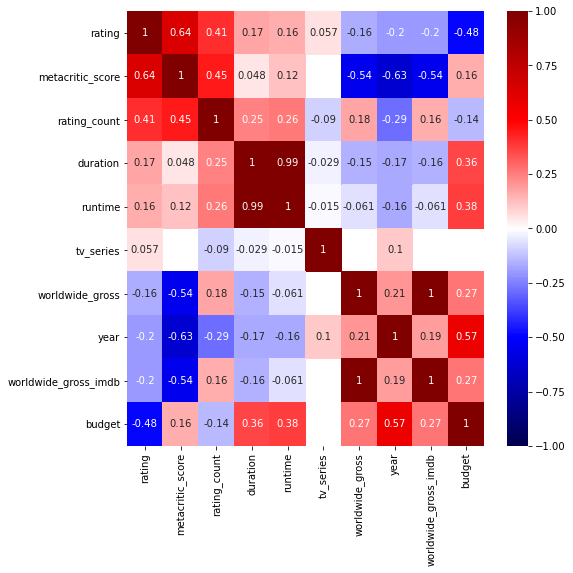

In [82]:
ix = films_df_reordered.iloc[:,:first_cast_column].corr().sort_values('rating', ascending=False).index
films_df_reordered_sorted = films_df_reordered.loc[:, ix]
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(films_df_reordered_sorted.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1, ax=ax);

In [83]:
#sns.heatmap(films_df_reordered.iloc[:,:first_cast_column].corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

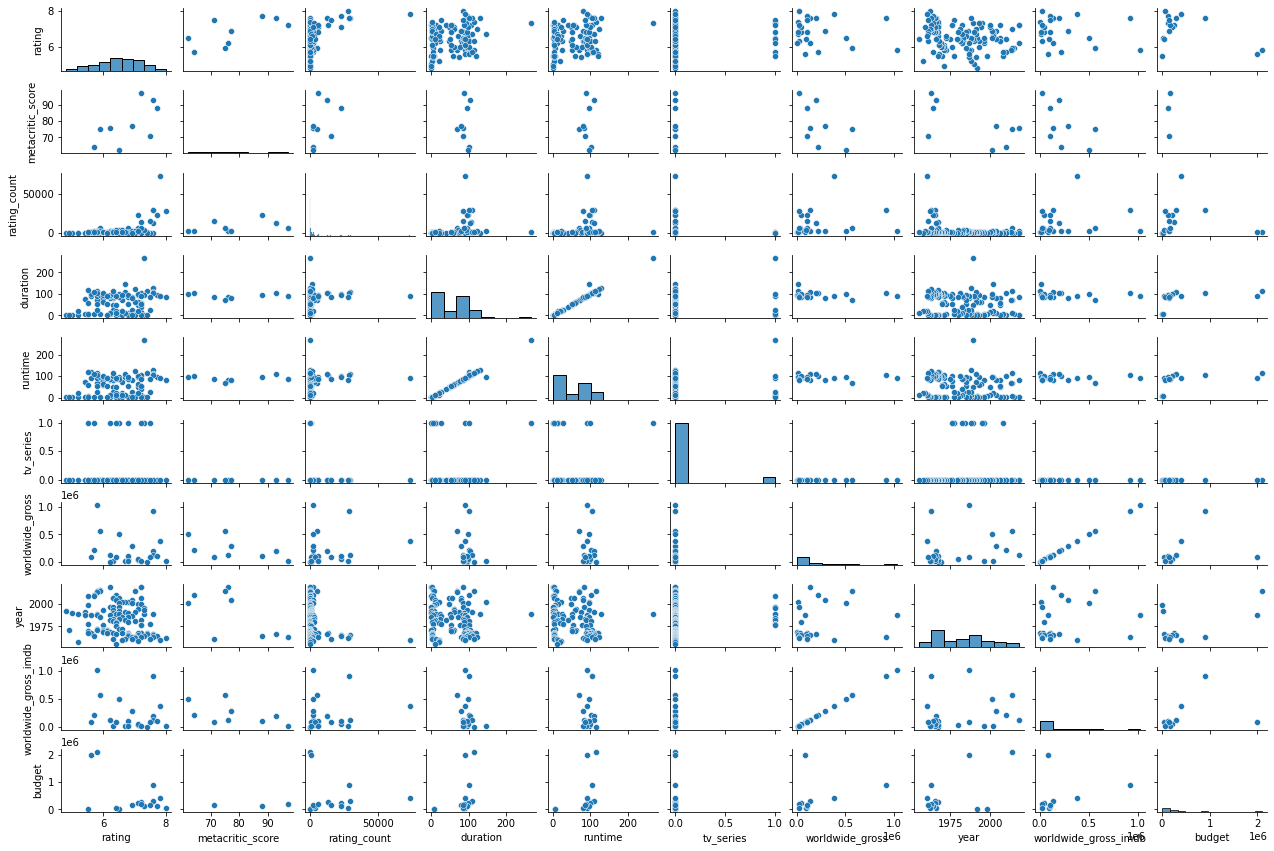

In [84]:
sns.pairplot(films_df_reordered_sorted.iloc[:,:first_cast_column], height=1.2, aspect=1.5);

#### Determine which columns have enough non-null values so they could be used

In [85]:
films_df_reordered['worldwide_gross'].value_counts(dropna=False)

NaN          103
47262.0        1
85018.0        1
222079.0       1
8132.0         1
132015.0       1
503548.0       1
104038.0       1
14378.0        1
380228.0       1
566423.0       1
15532.0        1
25000.0        1
200380.0       1
1028679.0      1
100665.0       1
47696.0        1
95209.0        1
106074.0       1
920144.0       1
134722.0       1
24296.0        1
36488.0        1
1149.0         1
24517.0        1
293681.0       1
Name: worldwide_gross, dtype: int64

In [86]:
films_to_analyze=films_df_reordered[(films_df_reordered['year'].notnull()) & (films_df_reordered['duration']>30) & (films_df_reordered['rating'].notnull()) & (films_df_reordered['cinematographer']!='') & (films_df_reordered['cinematographer'].notnull())]
films_to_analyze.iloc[:,5:15].head(10)


,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,metacritic_score,rating_count,tv_series,documentary,cinematographer
1,NaN,132015.0,132015.0,NaN,6.2,76.0,2314.0,0.0,0.0,Fabrice Aragno
4,2100000.0,NaN,NaN,NaN,5.8,NaN,319.0,0.0,0.0,Julian Atanassov
5,NaN,566423.0,566423.0,NaN,5.9,75.0,5487.0,0.0,0.0,Fabrice Aragno
7,NaN,NaN,NaN,NaN,5.8,NaN,313.0,0.0,0.0,Luís Branquinho
8,NaN,222079.0,222079.0,NaN,5.7,64.0,2539.0,0.0,0.0,Fabrice Aragno
17,NaN,293681.0,293681.0,NaN,6.9,77.0,2814.0,0.0,0.0,Julien Hirsch
19,NaN,14378.0,14378.0,NaN,6.7,NaN,1663.0,0.0,0.0,Ali Asad
22,NaN,503548.0,503548.0,NaN,6.5,62.0,2665.0,0.0,0.0,Julien Hirsch
28,NaN,25000.0,25000.0,NaN,6.3,NaN,934.0,0.0,0.0,Katell Djian
32,NaN,NaN,NaN,NaN,7.1,NaN,683.0,0.0,1.0,Christian Jacquenod


In [87]:
first_actor_column = (len(films_to_analyze.columns) - len(dict_of_all_actors))
first_actor_column

15

In [88]:
actor_columns = films_to_analyze.iloc[:, first_actor_column:].columns
actor_columns

Index(['Jean-Luc Godard', 'Anna Karina', 'Anne-Marie Miéville',
       'Anne Wiazemsky', 'Jean-Pierre Léaud', 'László Szabó',
       'Jean-Claude Brialy', 'Jean-Paul Belmondo', 'André S. Labarthe',
       'Juliet Berto',
       ...
       'Kim Kashkashian', 'Anton Mossine', 'Heinz Przbylski', 'Kerstin Boos',
       'H.J. Jurgen', 'Uwe Grzechowski', 'Jochen Gliscinsky', 'Iva Svarcová',
       'Elfi Gäbel', 'Carmen Mirando'],
      dtype='object', length=731)

In [89]:
films_to_analyze[actor_columns].sum()

Jean-Luc Godard        12.0
Anna Karina             7.0
Anne-Marie Miéville     3.0
Anne Wiazemsky          6.0
Jean-Pierre Léaud       5.0
                       ... 
Uwe Grzechowski         1.0
Jochen Gliscinsky       1.0
Iva Svarcová            1.0
Elfi Gäbel              1.0
Carmen Mirando          0.0
Length: 731, dtype: float64

In [90]:
actors_num_of_appearances = films_to_analyze[actor_columns].sum()
actors_num_of_appearances

Jean-Luc Godard        12.0
Anna Karina             7.0
Anne-Marie Miéville     3.0
Anne Wiazemsky          6.0
Jean-Pierre Léaud       5.0
                       ... 
Uwe Grzechowski         1.0
Jochen Gliscinsky       1.0
Iva Svarcová            1.0
Elfi Gäbel              1.0
Carmen Mirando          0.0
Length: 731, dtype: float64

In [91]:
appearances_threshold = 3
prevalent_actors_mask = (actors_num_of_appearances >= appearances_threshold)
prevalent_actors_mask

Jean-Luc Godard         True
Anna Karina             True
Anne-Marie Miéville     True
Anne Wiazemsky          True
Jean-Pierre Léaud       True
                       ...  
Uwe Grzechowski        False
Jochen Gliscinsky      False
Iva Svarcová           False
Elfi Gäbel             False
Carmen Mirando         False
Length: 731, dtype: bool

In [92]:
prevalent_actor_columns = actor_columns[prevalent_actors_mask]
prevalent_actor_columns 

Index(['Jean-Luc Godard', 'Anna Karina', 'Anne-Marie Miéville',
       'Anne Wiazemsky', 'Jean-Pierre Léaud', 'László Szabó',
       'Jean-Claude Brialy', 'Jean-Paul Belmondo', 'André S. Labarthe',
       'Juliet Berto', 'Myriem Roussel', 'Jean-Pierre Cassel',
       'Georges Staquet', 'Claude Brasseur'],
      dtype='object')

#### These next few cells are legacy  -----------------------------------------

#### End of legacy code  -----------------------------------------

In [93]:
analysis_columns = ['title', 'year', 'duration', 'cinematographer', 'documentary', 'tv_series','rating', 'rating_count', *prevalent_actor_columns]

In [94]:
analysis_columns

['title',
 'year',
 'duration',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating',
 'rating_count',
 'Jean-Luc Godard',
 'Anna Karina',
 'Anne-Marie Miéville',
 'Anne Wiazemsky',
 'Jean-Pierre Léaud',
 'László Szabó',
 'Jean-Claude Brialy',
 'Jean-Paul Belmondo',
 'André S. Labarthe',
 'Juliet Berto',
 'Myriem Roussel',
 'Jean-Pierre Cassel',
 'Georges Staquet',
 'Claude Brasseur']

## Dataset partitioned for analysis

In [95]:
films_and_features_to_analyze_df = films_to_analyze[analysis_columns]

In [96]:
x_label = 'year'
y_label = 'rating'
x_ = films_and_features_to_analyze_df[x_label]
y_ = films_and_features_to_analyze_df[y_label]

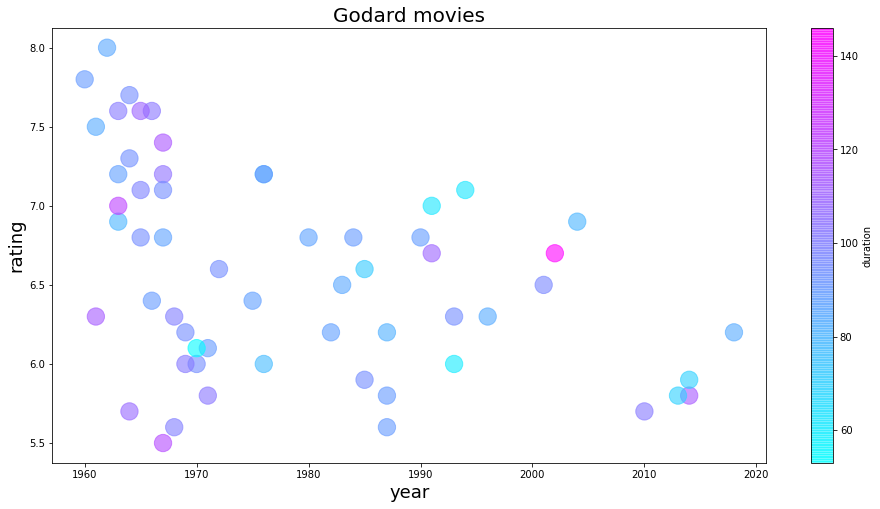

In [97]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'duration'
cm=films_and_features_to_analyze_df[color_dimension].tolist()

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension)

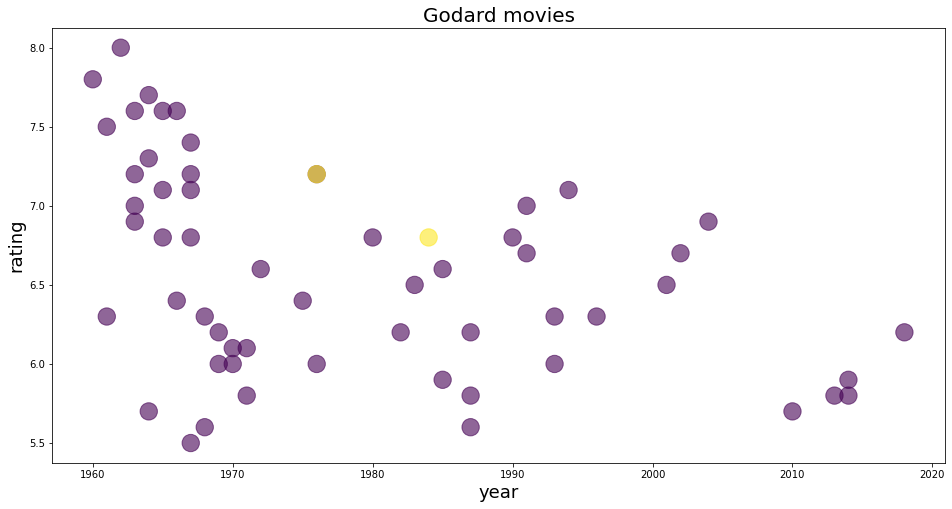

In [98]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))

In [99]:
x_label = 'year'
y_label = 'duration'
x_ = films_and_features_to_analyze_df[x_label]
y_ = films_and_features_to_analyze_df[y_label]

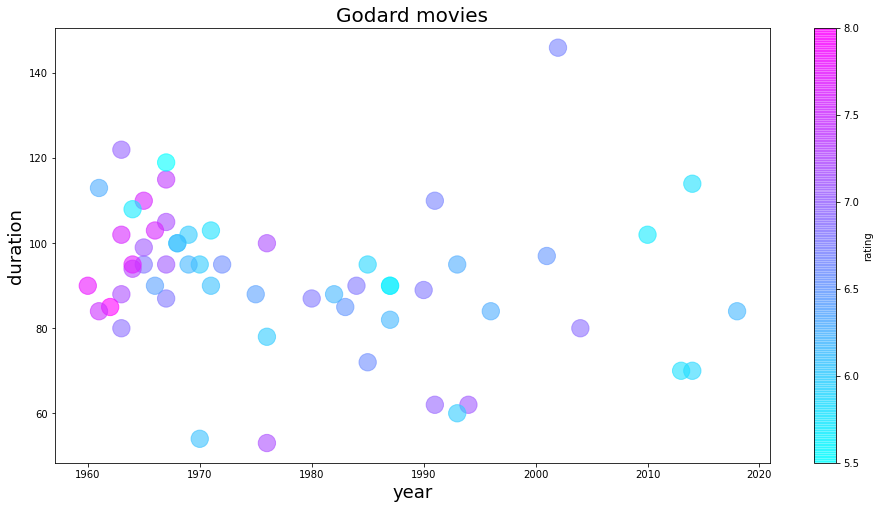

In [100]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'rating'
cm=films_and_features_to_analyze_df[color_dimension ].tolist()
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension )

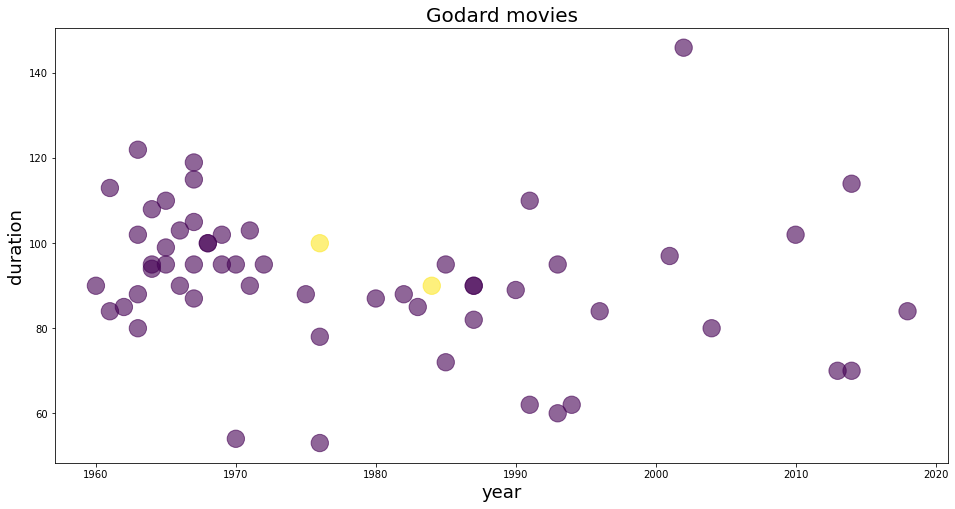

In [101]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))


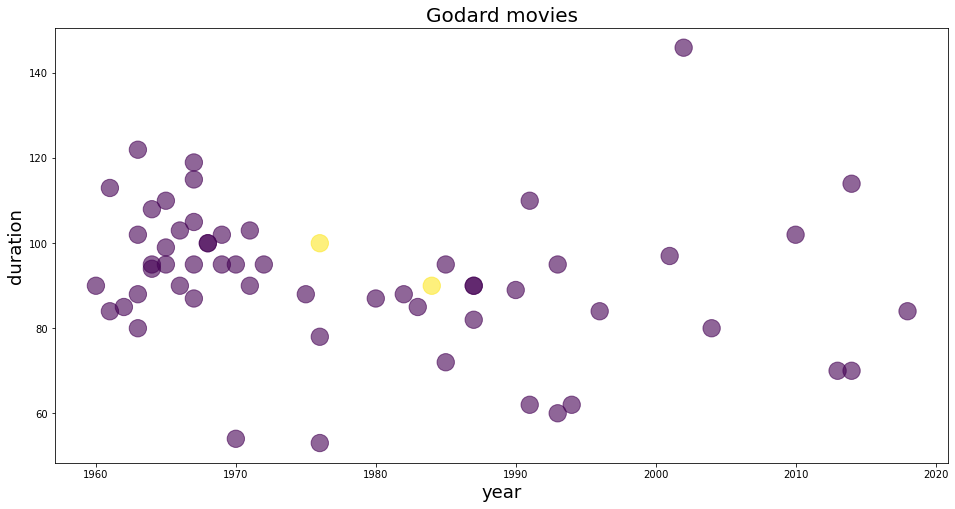

In [102]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))


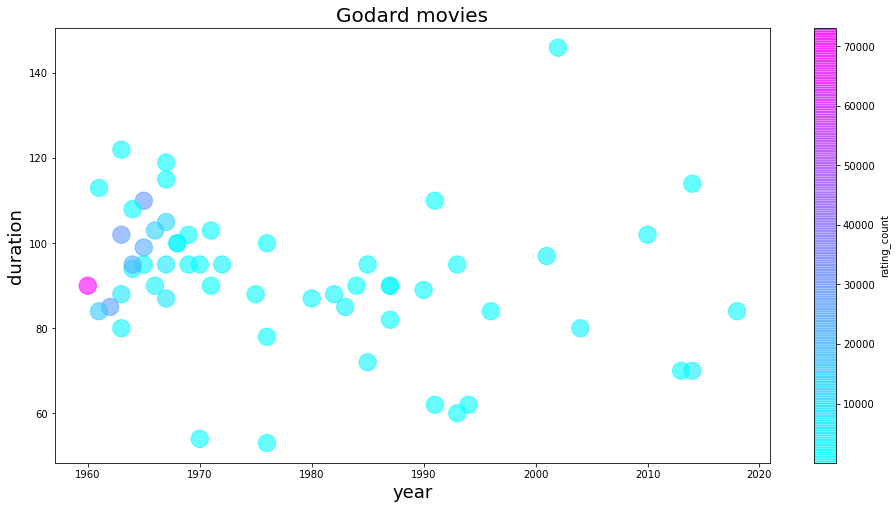

In [103]:
plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'rating_count'
cmap=plt.get_cmap("cool")
cm=films_and_features_to_analyze_df[color_dimension ].tolist()
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension )
#plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))

In [104]:
x_label = 'year'
y_label = 'rating_count'
x_ = films_and_features_to_analyze_df[x_label]
y_ = films_and_features_to_analyze_df[y_label]

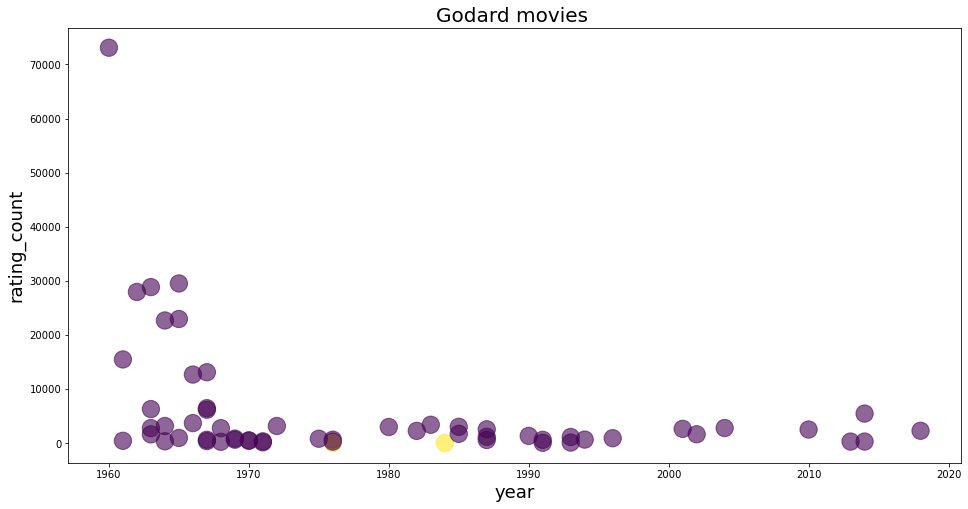

In [105]:
plt.figure(figsize=(16,8))
size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies ', fontsize='20')
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_df[category], s=(size_,))


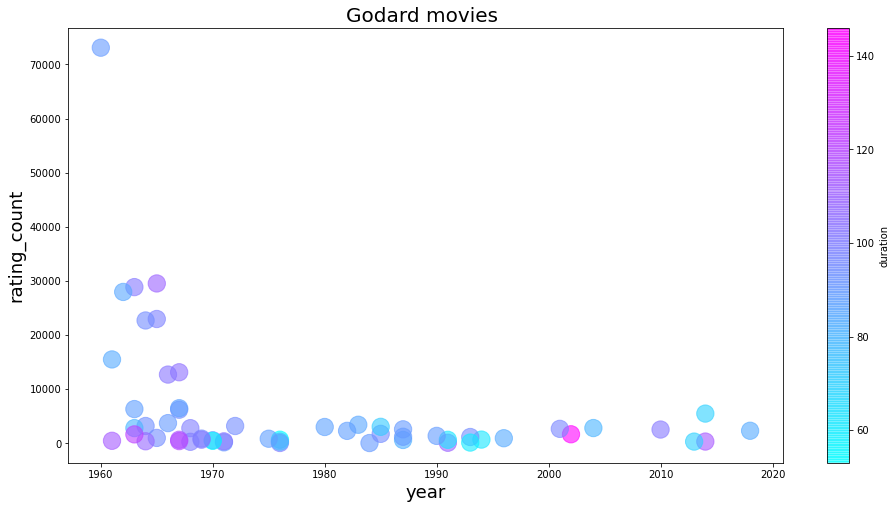

In [106]:
plt.figure(figsize=(16,8))
size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies ', fontsize='20')
color_dimension = 'duration'

cm=films_and_features_to_analyze_df[color_dimension ].tolist()
cmap=plt.get_cmap("cool")
category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension )

In [107]:
#films_and_features_to_analyze_df[films_and_features_to_analyze_df['tv_series']!=1]

In [108]:
x_label = 'year'
y_label = 'rating_count'
x_ = films_and_features_to_analyze_df[films_and_features_to_analyze_df['tv_series']!=1][x_label]
y_ = films_and_features_to_analyze_df[films_and_features_to_analyze_df['tv_series']!=1][y_label]

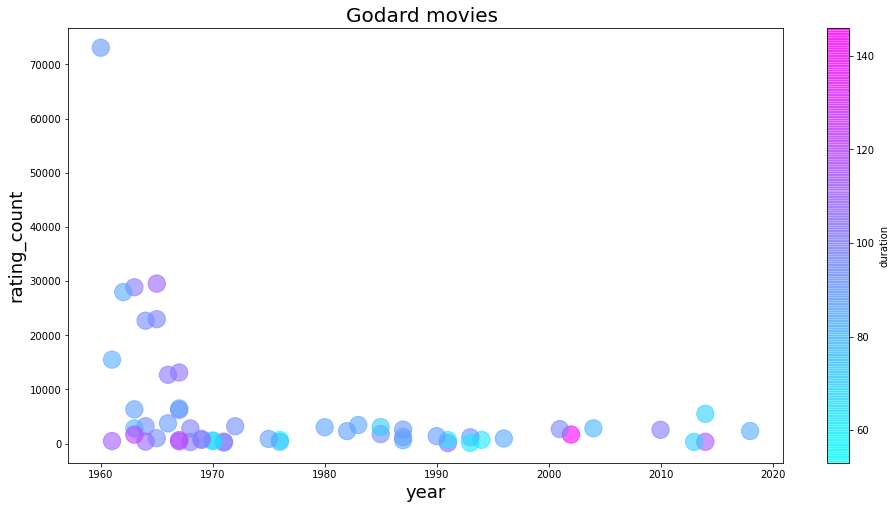

In [109]:
plt.figure(figsize=(16,8))
size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies ', fontsize='20')
color_dimension = 'duration'

cm=films_and_features_to_analyze_df[films_and_features_to_analyze_df['tv_series']!=1][color_dimension ].tolist()
cmap=plt.get_cmap("cool")
#category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension )

In [110]:
print( min(x_), max(x_))

1960.0 2018.0


In [111]:
from scipy import signal
signal.unit_impulse(1960) # come back to this to attempt to model "dirac impulse response" 
# for rating count based on year

array([1., 0., 0., ..., 0., 0., 0.])

In [112]:
films_and_features_to_analyze_df[films_and_features_to_analyze_df['duration'] <65]

,title,year,duration,cinematographer,documentary,tv_series,rating,rating_count,Jean-Luc Godard,Anna Karina,...,Jean-Pierre Léaud,László Szabó,Jean-Claude Brialy,Jean-Paul Belmondo,André S. Labarthe,Juliet Berto,Myriem Roussel,Jean-Pierre Cassel,Georges Staquet,Claude Brasseur
32,JLG/JLG - autoportrait de décembre,1994.0,62.0,Christian Jacquenod,1.0,0.0,7.1,683.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
35,Les enfants jouent à la Russie,1993.0,60.0,Caroline Champetier,0.0,0.0,6.0,131.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
40,Germany Year 90 Nine Zero,1991.0,62.0,Stepan Benda,0.0,0.0,7.0,641.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
74,Ici et ailleurs,1976.0,53.0,William Lubtchansky,1.0,0.0,7.2,665.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,See You at Mao,1970.0,54.0,Charles Stewart,1.0,0.0,6.1,453.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Breakdown by **cinematographers** Jack E. Cox, Robert Burks, and Bernard Knowles 

In [113]:
cinematographer = 'Jack E. Cox'

In [114]:
ctgrphr_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']==cinematographer]
other_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']!=cinematographer]


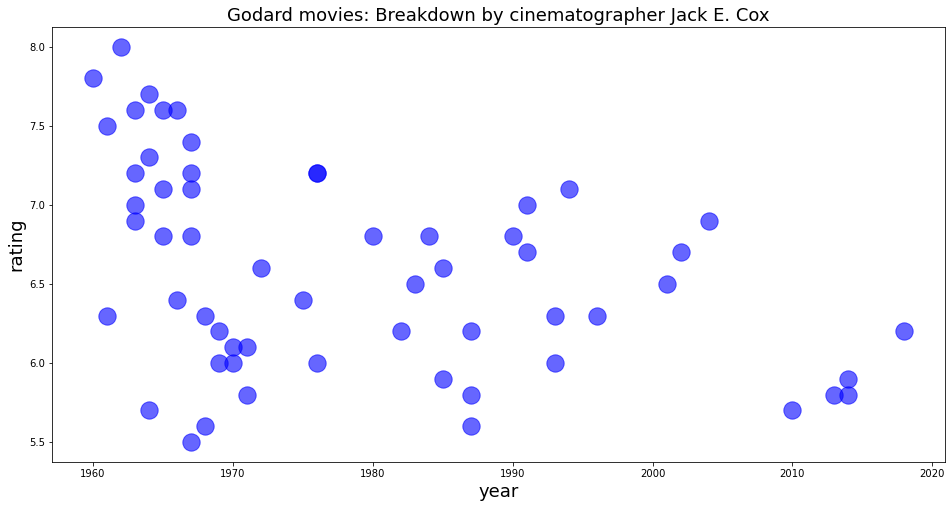

In [115]:
x_label = 'year'
y_label = 'rating'

x_cox = ctgrphr_flix[x_label]
y_cox = ctgrphr_flix[y_label]
x_non_cox = other_flix[x_label]
y_non_cox = other_flix[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies: Breakdown by cinematographer ' + cinematographer, fontsize='18')

category = 'tv_series'
plt.scatter(x=x_cox, y=y_cox, marker='o', alpha=alpha_, c = 'r', s=(size_,))
plt.scatter(x=x_non_cox, y=y_non_cox, marker='o', alpha=alpha_, c = 'b', s=(size_,))

plt.show()

In [116]:
cinematographer = 'Robert Burks'

In [117]:

ctgrphr_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']==cinematographer]
other_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']!=cinematographer]


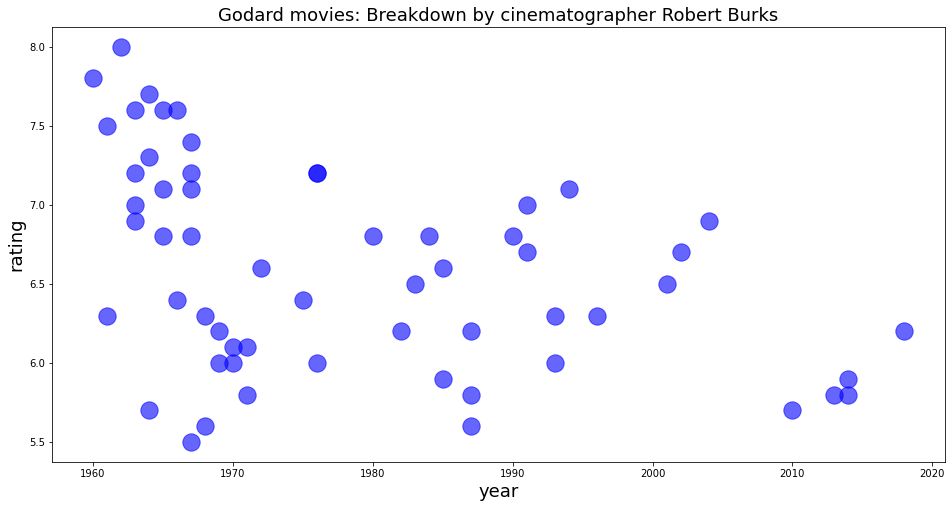

In [118]:
x_label = 'year'
y_label = 'rating'

x_cox = ctgrphr_flix[x_label]
y_cox = ctgrphr_flix[y_label]
x_non_cox = other_flix[x_label]
y_non_cox = other_flix[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies: Breakdown by cinematographer ' + cinematographer, fontsize='18')

category = 'tv_series'
plt.scatter(x=x_cox, y=y_cox, marker='o', alpha=alpha_, c = 'r', s=(size_,))
plt.scatter(x=x_non_cox, y=y_non_cox, marker='o', alpha=alpha_, c = 'b', s=(size_,))

plt.show()

In [119]:
cinematographer = 'Bernard Knowles'

In [120]:

ctgrphr_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']==cinematographer]
other_flix = films_and_features_to_analyze_df[films_and_features_to_analyze_df['cinematographer']!=cinematographer]


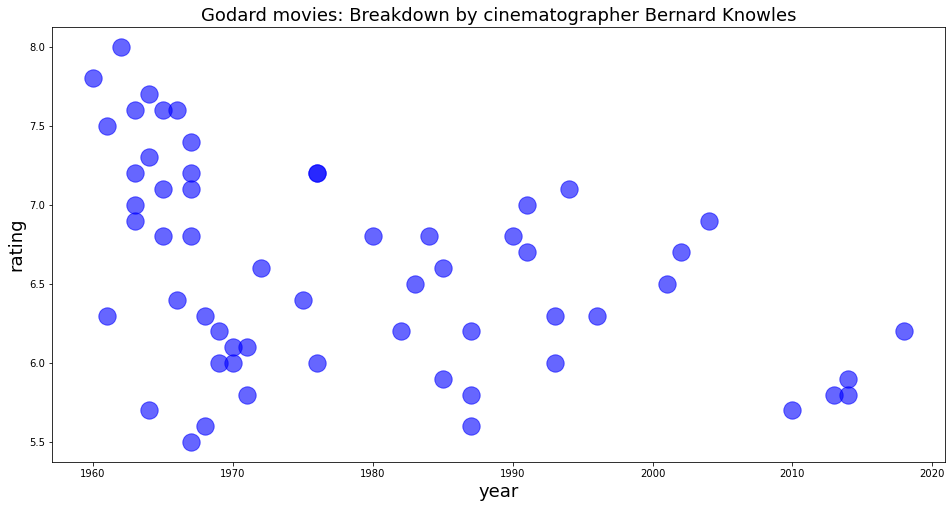

In [121]:
x_label = 'year'
y_label = 'rating'

x_cox = ctgrphr_flix[x_label]
y_cox = ctgrphr_flix[y_label]
x_non_cox = other_flix[x_label]
y_non_cox = other_flix[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies: ' + 'Breakdown by cinematographer ' + cinematographer, fontsize='18')

category = 'tv_series'
plt.scatter(x=x_cox, y=y_cox, marker='o', alpha=alpha_, c = 'r', s=(size_,))
plt.scatter(x=x_non_cox, y=y_non_cox, marker='o', alpha=alpha_, c = 'b', s=(size_,))

plt.show()

#### Recode misc. cinematographers to `OTHER` to ameliorate issue of not dropping a column and also to increase the chance it will occur in the test set as well

In [122]:
cinematographer_include_threshold = films_and_features_to_analyze_df['cinematographer'].value_counts().min()
cinematographer_include_threshold

1

In [123]:
value_counts = films_and_features_to_analyze_df['cinematographer'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= cinematographer_include_threshold].index
films_and_features_to_analyze_df['cinematographer'].replace(to_remove, 'OTHER', inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


### Regression analysis on `rating`,  `duration`, and `year` etc

#### `rating` as target

### Train Test Split

In [124]:
films_and_features_to_analyze_df.columns # review columns we start with

Index(['title', 'year', 'duration', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'rating_count', 'Jean-Luc Godard', 'Anna Karina',
       'Anne-Marie Miéville', 'Anne Wiazemsky', 'Jean-Pierre Léaud',
       'László Szabó', 'Jean-Claude Brialy', 'Jean-Paul Belmondo',
       'André S. Labarthe', 'Juliet Berto', 'Myriem Roussel',
       'Jean-Pierre Cassel', 'Georges Staquet', 'Claude Brasseur'],
      dtype='object')

In [125]:
selected_cols = [*films_and_features_to_analyze_df.columns[1:6], *films_and_features_to_analyze_df.columns[7:]]

In [126]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Preprocessing

#### Categorical Variable Preprocessing

In [128]:
cat_ohe_vars = ['cinematographer']
X_train_cat_ohe = X_train[cat_ohe_vars]
#X_train_cat_ohe 

#### OneHotEncoding

In [129]:
#ohe = OneHotEncoder(sparse=False, drop='first')
ohe = OneHotEncoder(sparse=False,  handle_unknown='ignore')
ohe.fit(X_train_cat_ohe)
cats_ohe = ohe.transform(X_train_cat_ohe)


In [130]:
columns=ohe.get_feature_names(cat_ohe_vars)

columns

array(['cinematographer_Caroline Champetier',
       'cinematographer_Fabrice Aragno',
       'cinematographer_Jean-Luc Godard', 'cinematographer_Julien Hirsch',
       'cinematographer_OTHER', 'cinematographer_Raoul Coutard',
       'cinematographer_William Lubtchansky'], dtype=object)

In [131]:
X_train_cat_ohe_df = pd.DataFrame(cats_ohe, columns=columns, index=X_train_cat_ohe.index)
X_train_cat_ohe_df.head()

,cinematographer_Caroline Champetier,cinematographer_Fabrice Aragno,cinematographer_Jean-Luc Godard,cinematographer_Julien Hirsch,cinematographer_OTHER,cinematographer_Raoul Coutard,cinematographer_William Lubtchansky
88,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22,0.0,0.0,0.0,1.0,0.0,0.0,0.0
110,0.0,0.0,0.0,0.0,0.0,1.0,0.0
96,0.0,0.0,0.0,0.0,0.0,1.0,0.0
100,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Repeating transformations on testing set

In [132]:
X_test_cat_ohe = X_test[['cinematographer']]
X_test_cat_ohe
cats_ohe_test = ohe.transform(X_test_cat_ohe)

cat_ohe_columns = ohe.get_feature_names(['cinematographer'])
X_test_cat_ohe_df = pd.DataFrame(cats_ohe_test, columns=cat_ohe_columns)

### Continous Variable Preprocessing

#### Select continuous variables from training set

In [133]:
X_train_cont = X_train[['year', 'duration', 'rating_count']]
X_train_cont.head(70)



,year,duration,rating_count
88,1969.0,95.0,868.0
22,2001.0,97.0,2665.0
110,1964.0,94.0,3194.0
96,1967.0,105.0,13124.0
100,1967.0,87.0,6484.0
40,1991.0,62.0,641.0
104,1966.0,103.0,12697.0
116,1963.0,122.0,1641.0
121,1961.0,113.0,460.0
75,1976.0,100.0,55.0


####  scale the continuous variables in the train set

In [134]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont)
X_train_scaled = ss.transform(X_train_cont)

cont_columns = X_train_cont.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()


,year,duration,rating_count
88,-0.646292,0.176522,-0.370510
22,1.299654,0.292406,-0.220999
110,-0.950346,0.118579,-0.176986
96,-0.767913,0.755944,0.649192
100,-0.767913,-0.287016,0.096742


#### select and scale the continuous variables in the test set

In [135]:
X_test_cont = X_test[['year', 'duration', 'rating_count']]
X_test_cont.head()

,year,duration,rating_count
82,1971.0,90.0,169.0
17,2004.0,80.0,2814.0
7,2013.0,70.0,313.0
92,1968.0,100.0,275.0
80,1972.0,95.0,3194.0


In [136]:
X_test_scaled = ss.transform(X_test_cont)

cont_columns = X_test_cont.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,year,duration,rating_count
82,-0.524670,-0.113189,-0.428667
17,1.482087,-0.692612,-0.208602
7,2.029384,-1.272034,-0.416686
92,-0.707103,0.466233,-0.419848
80,-0.463859,0.176522,-0.176986


### Combine the continuous, categorical, and ohe cat features for our testing set


In [137]:
cat_columns = ['documentary', 'tv_series', *prevalent_actor_columns]
X_train_cat_df = X_train[cat_columns]


In [138]:
X_train_combined = pd.concat([X_train_scaled_df, X_train_cat_ohe_df, X_train_cat_df, ], axis='columns')

X_train_combined.head(10)

,year,duration,rating_count,cinematographer_Caroline Champetier,cinematographer_Fabrice Aragno,cinematographer_Jean-Luc Godard,cinematographer_Julien Hirsch,cinematographer_OTHER,cinematographer_Raoul Coutard,cinematographer_William Lubtchansky,...,Jean-Pierre Léaud,László Szabó,Jean-Claude Brialy,Jean-Paul Belmondo,André S. Labarthe,Juliet Berto,Myriem Roussel,Jean-Pierre Cassel,Georges Staquet,Claude Brasseur
88,-0.646292,0.176522,-0.370510,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
22,1.299654,0.292406,-0.220999,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110,-0.950346,0.118579,-0.176986,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,-0.767913,0.755944,0.649192,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,-0.767913,-0.287016,0.096742,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
40,0.691546,-1.735572,-0.389396,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
104,-0.828724,0.640059,0.613665,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116,-1.011157,1.740962,-0.306196,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
121,-1.132778,1.219482,-0.404456,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
75,-0.220616,0.466233,-0.438152,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
X_train.shape

(43, 20)

### Combine the continuous and categorical features for our testing set


In [140]:
X_test_cat_df = X_test[cat_columns]

In [141]:
X_test_scaled_df.shape[0] == X_test_cat_df.shape[0] == X_test_cat_ohe_df.shape[0]


True

In [142]:
X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True) ], axis=1)
#X_test_combined = pd.concat([X_test_scaled_df, X_test_cat_ohe_df, X_test_cat_df ], axis=1)

X_test_combined

,year,duration,rating_count,cinematographer_Caroline Champetier,cinematographer_Fabrice Aragno,cinematographer_Jean-Luc Godard,cinematographer_Julien Hirsch,cinematographer_OTHER,cinematographer_Raoul Coutard,cinematographer_William Lubtchansky,...,Jean-Pierre Léaud,László Szabó,Jean-Claude Brialy,Jean-Paul Belmondo,André S. Labarthe,Juliet Berto,Myriem Roussel,Jean-Pierre Cassel,Georges Staquet,Claude Brasseur
0,-0.524670,-0.113189,-0.428667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.482087,-0.692612,-0.208602,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.029384,-1.272034,-0.416686,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.707103,0.466233,-0.419848,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.463859,0.176522,-0.176986,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.326681,0.176522,-0.297793,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,-0.646292,0.582117,-0.387566,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-1.011157,0.582117,1.958264,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-0.585481,-2.199109,-0.405038,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-0.889535,0.408291,1.468215,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Now make predictions by instantiating the Linear Regression Model 

In [143]:
lr = LinearRegression()

lr.fit(X_train_combined, y_train)

LinearRegression()

In [144]:
lr.coef_

array([-0.25349014,  0.01808247, -0.03968867, -0.2787452 ,  0.00187529,
        0.03993805,  0.20820388, -0.084114  ,  0.10618719,  0.00665478,
        0.17981481,  1.08855972, -0.14219678,  0.29275112, -0.29322044,
       -0.6446656 ,  0.12302733, -0.45025061, -0.72926715,  0.75136795,
        0.62730448, -0.22121785, -0.09164896, -0.74317266,  0.19603534,
        0.61761286])

In [145]:
y_pred = lr.predict(X_test_combined)

y_pred

array([6.33023955, 6.29325483, 6.00218044, 6.85146253, 6.00620757,
       7.19591376, 6.71280979, 6.90249778, 6.82761167, 7.1807252 ,
       6.51977931, 6.79491133, 6.14075978, 7.92193665, 6.16546682])

In [146]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.68
r2: -0.09


In [147]:
print(r2)

-0.09326883226492844


In [148]:
score = lr.score(X_test_combined, y_test) 
score

-0.09326883226492844

# Focus on building up from fewer features
for instance the continous ones

### Train Test Split

In [149]:
films_and_features_to_analyze_df.columns # review columns we start with

Index(['title', 'year', 'duration', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'rating_count', 'Jean-Luc Godard', 'Anna Karina',
       'Anne-Marie Miéville', 'Anne Wiazemsky', 'Jean-Pierre Léaud',
       'László Szabó', 'Jean-Claude Brialy', 'Jean-Paul Belmondo',
       'André S. Labarthe', 'Juliet Berto', 'Myriem Roussel',
       'Jean-Pierre Cassel', 'Georges Staquet', 'Claude Brasseur'],
      dtype='object')

In [150]:
selected_cols = ['year', 'duration', 'rating_count']

In [151]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Preprocessing

## For now, ignore these categorical variables

#### Categorical Variable Preprocessing

#### OneHotEncoding

#### Repeating transformations on testing set

### Continous Variable Preprocessing

#### Select continuous variables from training set

In [153]:
X_train_cont = X_train[['year', 'duration', 'rating_count']]
X_train_cont.head()



,year,duration,rating_count
1,2018.0,84.0,2314.0
108,1965.0,99.0,22968.0
99,1967.0,119.0,402.0
43,1990.0,89.0,1366.0
96,1967.0,105.0,13124.0


####  scale the continuous variables in the train set

In [154]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont)
X_train_scaled = ss.transform(X_train_cont)

cont_columns = X_train_cont.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()


,year,duration,rating_count
1,2.597016,-0.385914,-0.329299
108,-0.874303,0.630064,1.299673
99,-0.743310,1.984702,-0.480097
43,0.763112,-0.047255,-0.404067
96,-0.743310,1.036456,0.523281


#### select and scale the continuous variables in the test set

In [155]:
X_test_cont = X_test[['year', 'duration', 'rating_count']]
X_test_cont.head()

,year,duration,rating_count
55,1984.0,90.0,45.0
111,1964.0,108.0,367.0
82,1971.0,90.0,169.0
4,2014.0,114.0,319.0
19,2002.0,146.0,1663.0


In [156]:
X_test_scaled = ss.transform(X_test_cont)

cont_columns = X_test_cont.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,year,duration,rating_count
55,0.370132,0.020477,-0.508254
111,-0.939800,1.239651,-0.482858
82,-0.481324,0.020477,-0.498474
4,2.335030,1.646043,-0.486643
19,1.549071,3.813464,-0.380643


### Combine the continuous, categorical, and ohe cat features for our testing set


## for now, ignore these categorical variables

## 'combine' will really just be the continuous variables

In [157]:
X_train_combined = pd.concat([X_train_scaled_df.reset_index(drop=True)], axis='columns')

X_train_combined.head()

,year,duration,rating_count
0,2.597016,-0.385914,-0.329299
1,-0.874303,0.630064,1.299673
2,-0.743310,1.984702,-0.480097
3,0.763112,-0.047255,-0.404067
4,-0.743310,1.036456,0.523281


In [158]:
X_train_combined.shape

(43, 3)

### Combine the continuous and categorical features for our testing set


In [159]:
#X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True) ], axis=1)
X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True) ], axis=1)

X_test_combined

,year,duration,rating_count
0,0.370132,0.020477,-0.508254
1,-0.939800,1.239651,-0.482858
2,-0.481324,0.020477,-0.498474
3,2.335030,1.646043,-0.486643
4,1.549071,3.813464,-0.380643
5,-0.612317,0.833260,-0.459512
6,-0.481324,0.900992,-0.483410
7,-1.136290,1.578311,-0.475523
8,-0.808807,0.900992,0.489604
9,-1.005297,0.833260,1.764215


### Now make predictions by instantiating the Linear Regression Model 

In [160]:
#X_train_combined

In [161]:
lr = LinearRegression()

lr.fit(X_train_combined,y_train)

LinearRegression()

In [162]:
lr.coef_

array([-0.21333116, -0.02523626,  0.29634639])

In [163]:

y_pred = lr.predict(X_test_combined)

y_pred

array([6.40013597, 6.65634388, 6.58467623, 5.94634295, 6.09072783,
       6.60365567, 6.56691951, 6.69188843, 6.9251309 , 7.34648388,
       6.67920025, 6.53852757, 6.2024987 , 6.07463181, 6.58965088])

In [164]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.56
r2: 0.26


In [165]:
score = lr.score(X_test_combined, y_test) 
score

0.2569187152957517

## Try to fit with just the year

In [166]:
lr = LinearRegression()

In [167]:
X_train_year_only = X_train_combined.iloc[:, :1]

In [168]:
X_test_year_only = X_test_combined.iloc[:, :1]

In [169]:
#X_train_year_only 

In [170]:
lr.fit(X_train_year_only, y_train)

LinearRegression()

In [171]:
lr.coef_

array([-0.31629295])

In [172]:
y_pred = lr.predict(X_test_year_only)

y_pred

array([6.51316244, 6.92748468, 6.78247189, 5.89167908, 6.14027242,
       6.82390412, 6.78247189, 6.98963301, 6.88605245, 6.94820079,
       6.90676856, 6.67889133, 6.0988402 , 5.97454353, 6.67889133])

In [173]:
y_test

55     6.8
111    5.7
82     6.1
4      5.8
19     6.7
89     6.0
83     5.8
121    6.3
104    7.6
114    7.6
107    6.8
76     6.0
17     6.9
8      5.7
74     7.2
Name: rating, dtype: float64

In [174]:
#y_test

In [175]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [176]:
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.68
r2: -0.11


## Try to fit with just the `year` and `duration`


In [177]:
lr = LinearRegression()

X_train_year_dur_only = X_train_combined.iloc[:, :2]

X_test_year_dur_only = X_test_combined.iloc[:, :2]

#X_train_year_only 

lr.fit(X_train_year_dur_only, y_train)

lr.coef_

y_pred = lr.predict(X_test_year_dur_only)

y_pred

y_test

#y_test

from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.68
r2: -0.11


## Try to fit with just the `year` and `rating_count`

In [178]:
X_train_combined[['year', 'rating_count']]

,year,rating_count
0,2.597016,-0.329299
1,-0.874303,1.299673
2,-0.743310,-0.480097
3,0.763112,-0.404067
4,-0.743310,0.523281
5,-1.136290,0.710044
6,-1.005297,-0.382378
7,-0.743310,-0.460301
8,0.959601,-0.420393
9,-0.677814,-0.490114


In [179]:
lr = LinearRegression()

X_train_year_rc_only = X_train_combined[['year', 'rating_count']]

X_test_year_rc_only = X_test_combined[['year', 'rating_count']]



lr.fit(X_train_year_rc_only, y_train)

lr.coef_

y_pred = lr.predict(X_test_year_rc_only)

y_pred

y_test


from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.56
r2: 0.25


## Feature engineer:  log(`year`) and and log(`rating_count`)

####  scale the continuous variables in the train set

In [180]:
X_train_cont_w_log = copy.deepcopy(X_train_cont) 
X_test_cont_w_log = copy.deepcopy(X_test_cont) 

X_train_cont_w_log['log_year'] = np.log(X_train_cont_w_log.year)
X_test_cont_w_log['log_year'] = np.log(X_test_cont_w_log.year)

X_train_cont_w_log['log_rating_count'] = np.log(X_train_cont_w_log.rating_count)
X_test_cont_w_log['log_rating_count'] = np.log(X_test_cont_w_log.rating_count)

In [181]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont_w_log)
X_train_scaled = ss.transform(X_train_cont_w_log)

cont_columns = X_train_cont_w_log.columns
#X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont_w_log.index)

X_train_scaled_df.head()

,year,duration,rating_count,log_year,log_rating_count
1,2.597016,-0.385914,-0.329299,2.583723,0.088994
108,-0.874303,0.630064,1.299673,-0.876324,1.558220
99,-0.743310,1.984702,-0.480097,-0.744070,-1.031450
43,0.763112,-0.047255,-0.404067,0.767253,-0.248423
96,-0.743310,1.036456,0.523281,-0.744070,1.199954


In [182]:
X_test_scaled = ss.transform(X_test_cont_w_log)

cont_columns = X_test_cont_w_log.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont_w_log.index)
#X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

,year,duration,rating_count,log_year,log_rating_count
55,0.370132,0.020477,-0.508254,0.374686,-2.433246
111,-0.939800,1.239651,-0.482858,-0.942501,-1.089761
82,-0.481324,0.020477,-0.498474,-0.479966,-1.586175
4,2.335030,1.646043,-0.486643,2.325776,-1.179492
19,1.549071,3.813464,-0.380643,1.548850,-0.122482


In [183]:
lr = LinearRegression()

lr.fit(X_train_scaled_df, y_train)

lr.coef_

y_pred = lr.predict(X_test_scaled_df)

y_pred

y_test


from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.52
r2: 0.35


In [184]:
lr.coef_

array([ 2.98266302, -0.02239433,  0.20158302, -3.17881165,  0.13399169])

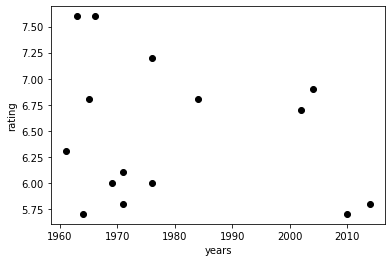

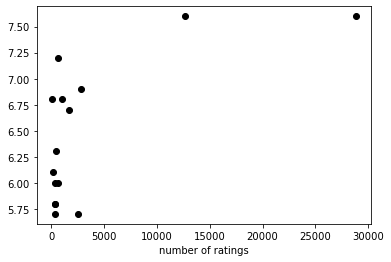

In [185]:
plt.ylabel("rating")
plt.scatter(X_test_cont_w_log['year'], y_test,  color='black')
plt.xlabel('years')
plt.show()
#plt.plot(X_test_cont_w_log['year'], y_pred, color='blue', linewidth=3)
plt.scatter(X_test_cont_w_log['rating_count'], y_test,  color='black')
plt.xlabel('number of ratings')
plt.show()

### Fit to `log_rating_count` and maybe `log_year`


In [186]:
lr = LinearRegression()

X_train_logs_only = X_train_scaled_df[['year','log_rating_count']]

X_test_logs_only = X_test_scaled_df[['year','log_rating_count']]



lr.fit(X_train_logs_only, y_train)

lr.coef_

y_pred = lr.predict(X_test_logs_only)

y_pred

y_test


from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))



r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 0.52
r2: 0.34


## Repartition data set to analyze `budget` and  `worldwide_gross`

In [187]:
films_to_analyze_financial_df = films_to_analyze[(films_to_analyze['budget'] > 0) & (films_df_reordered['worldwide_gross'] > 0)]

<ipython-input-187-e7ff25988abc>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  films_to_analyze_financial_df = films_to_analyze[(films_to_analyze['budget'] > 0) & (films_df_reordered['worldwide_gross'] > 0)]


In [189]:
first_actor_column = (len(films_to_analyze_financial_df.columns) - len(dict_of_all_actors))
first_actor_column


15

In [190]:
actor_columns = films_to_analyze_financial_df.iloc[:, first_actor_column:].columns
actor_columns


Index(['Jean-Luc Godard', 'Anna Karina', 'Anne-Marie Miéville',
       'Anne Wiazemsky', 'Jean-Pierre Léaud', 'László Szabó',
       'Jean-Claude Brialy', 'Jean-Paul Belmondo', 'André S. Labarthe',
       'Juliet Berto',
       ...
       'Kim Kashkashian', 'Anton Mossine', 'Heinz Przbylski', 'Kerstin Boos',
       'H.J. Jurgen', 'Uwe Grzechowski', 'Jochen Gliscinsky', 'Iva Svarcová',
       'Elfi Gäbel', 'Carmen Mirando'],
      dtype='object', length=731)

In [191]:
films_to_analyze[actor_columns].sum()

Jean-Luc Godard        12.0
Anna Karina             7.0
Anne-Marie Miéville     3.0
Anne Wiazemsky          6.0
Jean-Pierre Léaud       5.0
                       ... 
Uwe Grzechowski         1.0
Jochen Gliscinsky       1.0
Iva Svarcová            1.0
Elfi Gäbel              1.0
Carmen Mirando          0.0
Length: 731, dtype: float64

In [195]:
actors_num_of_appearances = films_to_analyze_financial_df[actor_columns].sum()
actors_num_of_appearances

Jean-Luc Godard        2.0
Anna Karina            7.0
Anne-Marie Miéville    0.0
Anne Wiazemsky         0.0
Jean-Pierre Léaud      1.0
                      ... 
Uwe Grzechowski        0.0
Jochen Gliscinsky      0.0
Iva Svarcová           0.0
Elfi Gäbel             0.0
Carmen Mirando         0.0
Length: 731, dtype: float64

In [196]:
appearances_threshold = 3
prevalent_actors_mask = (actors_num_of_appearances >= appearances_threshold)
prevalent_actors_mask

Jean-Luc Godard        False
Anna Karina             True
Anne-Marie Miéville    False
Anne Wiazemsky         False
Jean-Pierre Léaud      False
                       ...  
Uwe Grzechowski        False
Jochen Gliscinsky      False
Iva Svarcová           False
Elfi Gäbel             False
Carmen Mirando         False
Length: 731, dtype: bool

In [197]:
prevalent_actor_columns = actor_columns[prevalent_actors_mask]
prevalent_actor_columns 


Index(['Anna Karina', 'Jean-Paul Belmondo'], dtype='object')

In [198]:
analysis_columns = ['title', 'year', 'duration', 'budget', 'worldwide_gross','cinematographer', 'documentary', 'tv_series','rating', 'rating_count', *prevalent_actor_columns]
analysis_columns


['title',
 'year',
 'duration',
 'budget',
 'worldwide_gross',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating',
 'rating_count',
 'Anna Karina',
 'Jean-Paul Belmondo']

In [199]:
films_and_features_to_analyze_financial_df = films_to_analyze_financial_df[analysis_columns]

In [200]:
films_and_features_to_analyze_financial_df.head(10)

,title,year,duration,budget,worldwide_gross,cinematographer,documentary,tv_series,rating,rating_count,Anna Karina,Jean-Paul Belmondo
53,King Lear,1987.0,90.0,2000000.0,85018.0,Sophie Maintigneux,0.0,0.0,5.6,1204.0,0.0,0.0
103,Made in U.S.A,1966.0,90.0,50000.0,95209.0,Raoul Coutard,0.0,0.0,6.4,3726.0,1.0,0.0
106,Pierrot le Fou,1965.0,110.0,300000.0,134722.0,Raoul Coutard,0.0,0.0,7.6,29534.0,1.0,1.0
108,Alphaville,1965.0,99.0,220000.0,47696.0,Raoul Coutard,0.0,0.0,7.1,22968.0,1.0,0.0
112,Band of Outsiders,1964.0,95.0,120000.0,106074.0,Raoul Coutard,0.0,0.0,7.7,22694.0,1.0,0.0
114,Contempt,1963.0,102.0,900000.0,920144.0,Raoul Coutard,0.0,0.0,7.6,28858.0,0.0,0.0
117,Le Petit Soldat,1963.0,88.0,180000.0,24296.0,Raoul Coutard,0.0,0.0,7.2,6321.0,1.0,0.0
119,Vivre Sa Vie,1962.0,85.0,64000.0,24517.0,Raoul Coutard,0.0,0.0,8.0,27968.0,1.0,0.0
122,A Woman Is a Woman,1961.0,84.0,160000.0,100665.0,Raoul Coutard,0.0,0.0,7.5,15492.0,1.0,1.0
125,Breathless,1960.0,90.0,400000.0,380228.0,Raoul Coutard,0.0,0.0,7.8,73103.0,0.0,1.0


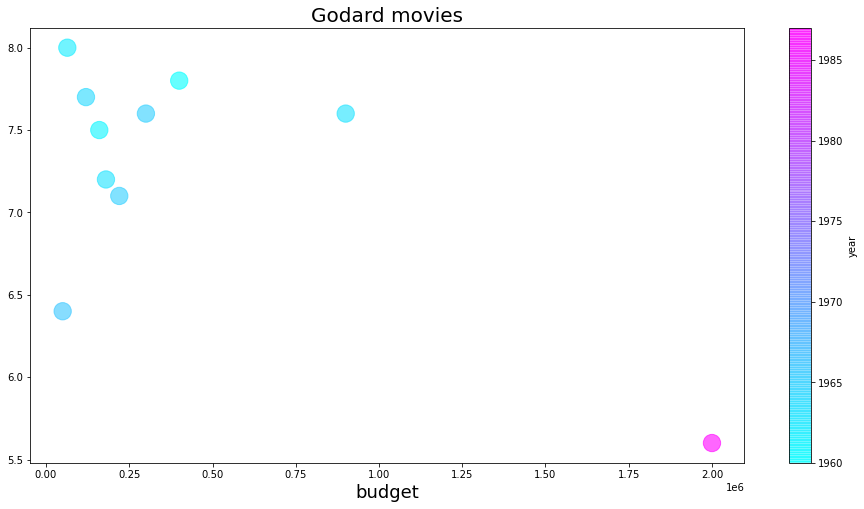

In [201]:
x_label = 'budget'
y_label = 'rating'
x_ = films_and_features_to_analyze_financial_df[x_label]
y_ = films_and_features_to_analyze_financial_df[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
#plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'year'
cm=films_and_features_to_analyze_financial_df[color_dimension].tolist()

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension)

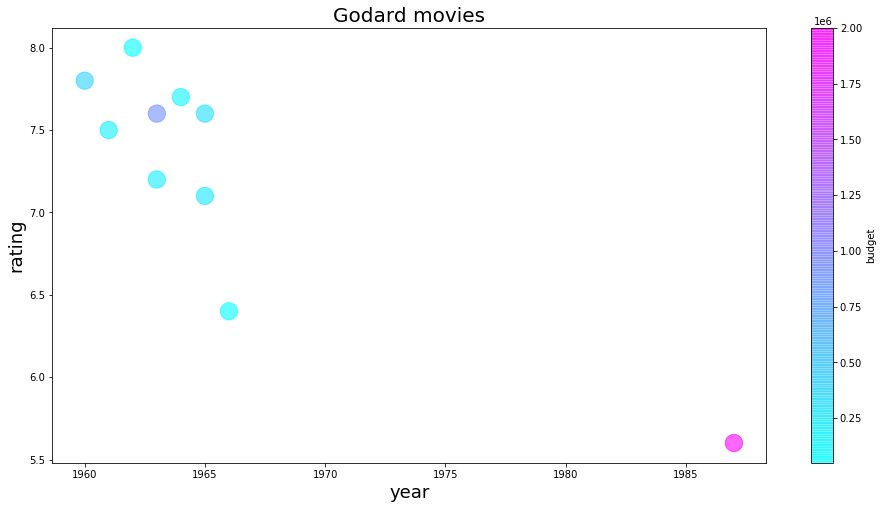

In [204]:
x_label = 'year'
y_label = 'rating'
x_ = films_and_features_to_analyze_financial_df[x_label]
y_ = films_and_features_to_analyze_financial_df[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'budget'
cm=films_and_features_to_analyze_financial_df[color_dimension].tolist()

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension)

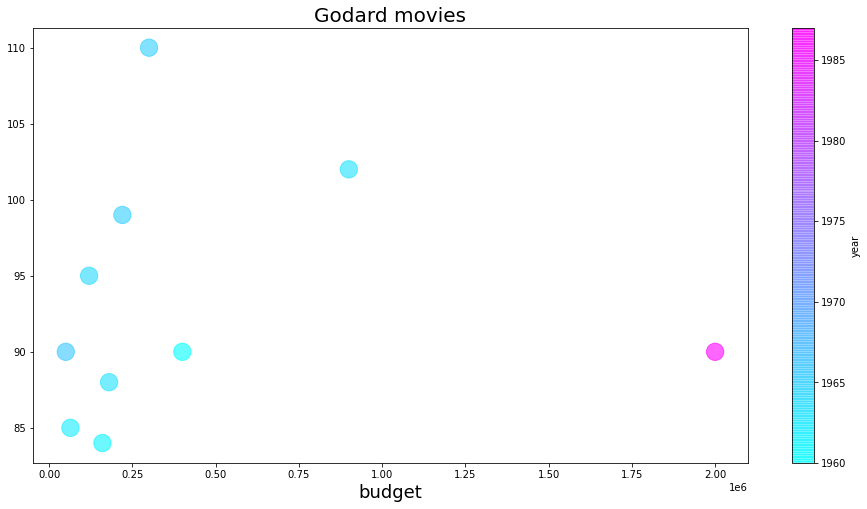

In [205]:
x_label = 'budget'
y_label = 'duration'
x_ = films_and_features_to_analyze_financial_df[x_label]
y_ = films_and_features_to_analyze_financial_df[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
#plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
cmap=plt.get_cmap("cool")
color_dimension = 'year'
cm=films_and_features_to_analyze_financial_df[color_dimension].tolist()

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c=cm,cmap="cool", s=(size_,))
plt.colorbar(label=color_dimension)

In [206]:
cinematographer_include_threshold = films_and_features_to_analyze_df['cinematographer'].value_counts().min()
cinematographer_include_threshold

2

In [207]:
value_counts = films_and_features_to_analyze_financial_df['cinematographer'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= cinematographer_include_threshold].index
films_and_features_to_analyze_financial_df['cinematographer'].replace(to_remove, 'OTHER', inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [208]:
selected_cols = [*films_and_features_to_analyze_financial_df.columns[1:8], *films_and_features_to_analyze_financial_df.columns[9:]]

In [209]:
selected_cols

['year',
 'duration',
 'budget',
 'worldwide_gross',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating_count',
 'Anna Karina',
 'Jean-Paul Belmondo']

In [210]:
X= films_and_features_to_analyze_financial_df[selected_cols]
y= films_and_features_to_analyze_financial_df['rating']

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [212]:
### Preprocessing

#### Categorical Variable Preprocessing

cat_ohe_vars = ['cinematographer']
X_train_cat_ohe = X_train[cat_ohe_vars]
#X_train_cat_ohe 

#### OneHotEncoding

In [213]:


#ohe = OneHotEncoder(sparse=False, drop='first')
ohe = OneHotEncoder(sparse=False,  handle_unknown='ignore')
ohe.fit(X_train_cat_ohe)
cats_ohe = ohe.transform(X_train_cat_ohe)


columns=ohe.get_feature_names(cat_ohe_vars)

columns

X_train_cat_ohe_df = pd.DataFrame(cats_ohe, columns=columns, index=X_train_cat_ohe.index)
X_train_cat_ohe_df.head()

#### Repeating transformations on testing set

X_test_cat_ohe = X_test[['cinematographer']]
X_test_cat_ohe
cats_ohe_test = ohe.transform(X_test_cat_ohe)

cat_ohe_columns = ohe.get_feature_names(['cinematographer'])
X_test_cat_ohe_df = pd.DataFrame(cats_ohe_test, columns=cat_ohe_columns)

### Continous Variable Preprocessing

#### Select continuous variables from training set

X_train_cont = X_train[['year', 'duration', 'budget','rating_count']]
X_train_cont.head(70)



####  scale the continuous variables in the train set

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont)
X_train_scaled = ss.transform(X_train_cont)

cont_columns = X_train_cont.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()


#### select and scale the continuous variables in the test set

X_test_cont = X_test[['year', 'duration', 'budget','rating_count']]
X_test_cont.head()

X_test_scaled = ss.transform(X_test_cont)

cont_columns = X_test_cont.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test_cont.index)

X_test_scaled_df.head()

### Combine the continuous, categorical, and ohe cat features for our testing set


cat_columns = ['documentary', 'tv_series', *prevalent_actor_columns]
X_train_cat_df = X_train[cat_columns]


X_train_combined = pd.concat([X_train_scaled_df, X_train_cat_ohe_df, X_train_cat_df, ], axis='columns')

X_train_combined.head(10)

X_train.shape

### Combine the continuous and categorical features for our testing set


X_test_cat_df = X_test[cat_columns]

X_test_scaled_df.shape[0] == X_test_cat_df.shape[0] == X_test_cat_ohe_df.shape[0]


X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True) ], axis=1)
#X_test_combined = pd.concat([X_test_scaled_df, X_test_cat_ohe_df, X_test_cat_df ], axis=1)

X_test_combined

### Now make predictions by instantiating the Linear Regression Model 

lr = LinearRegression()

lr.fit(X_train_combined, y_train)

lr.coef_

y_pred = lr.predict(X_test_combined)

y_pred

from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

print(r2)

score = lr.score(X_test_combined, y_test) 
score

RMSE: 12.57
r2: -190.23
-190.2286609691433


-190.2286609691433

### Look at continous variable including `budget`

In [214]:
films_and_features_to_analyze_financial_df.columns

selected_cols = ['budget', 'rating_count']
#selected_cols = ['year', 'duration', 'budget', 'rating_count']
#selected_cols = ['budget']
X= films_and_features_to_analyze_financial_df[selected_cols]
y= films_and_features_to_analyze_financial_df['rating']

In [215]:


X_train, X_test, y_train, y_test = train_test_split(X, y)

In [216]:
X_train.columns

Index(['budget', 'rating_count'], dtype='object')

In [217]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_train_scaled

array([[ 0.57197668,  1.08730082],
       [-0.54776603, -0.05698047],
       [-0.69302995,  1.01110672],
       [-0.71421427, -1.0642836 ],
       [ 2.2364591 , -1.28019542],
       [-0.33592281,  1.1451741 ],
       [-0.51750271, -0.84212215]])

In [218]:
cont_columns = X_train.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont.index)

X_train_scaled_df.head()

,budget,rating_count
108,0.571977,1.087301
122,-0.547766,-0.056980
106,-0.693030,1.011107
114,-0.714214,-1.064284
117,2.236459,-1.280195


In [219]:
X_train_combined = pd.concat([X_train_scaled_df.reset_index(drop=True)], axis='columns')

X_train_combined.head()

,budget,rating_count
0,0.571977,1.087301
1,-0.547766,-0.056980
2,-0.693030,1.011107
3,-0.714214,-1.064284
4,2.236459,-1.280195


In [220]:
#X_test = X_test[['year', 'budget','rating_count']]

X_test = X_test[selected_cols]
X_test.head()

X_test_scaled = ss.transform(X_test)

cont_columns = X_test.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=cont_columns, index=X_test.index)

X_test_scaled_df.head()

,budget,rating_count
112,-0.608293,0.559592
108,-0.456976,0.583050
125,-0.184606,4.875175


In [221]:
X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True) ], axis=1)

X_test_combined

,budget,rating_count
0,-0.608293,0.559592
1,-0.456976,0.583050
2,-0.184606,4.875175


In [222]:
lr = LinearRegression()

lr.fit(X_train_combined,y_train)

lr.coef_

array([-0.35418722,  0.54870207])

In [223]:
y_pred = lr.predict(X_test_combined)

y_pred

array([7.65107046, 7.61034725, 9.8689752 ])

In [224]:

from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

RMSE: 1.23
r2: -14.85


In [225]:
X_train_combined.head()

,budget,rating_count
0,0.571977,1.087301
1,-0.547766,-0.056980
2,-0.693030,1.011107
3,-0.714214,-1.064284
4,2.236459,-1.280195


In [226]:
X_train_cont

,year,duration,budget,rating_count
108,1965.0,99.0,220000.0,22968.0
122,1961.0,84.0,160000.0,15492.0
106,1965.0,110.0,300000.0,29534.0
114,1963.0,102.0,900000.0,28858.0
117,1963.0,88.0,180000.0,6321.0
119,1962.0,85.0,64000.0,27968.0
112,1964.0,95.0,120000.0,22694.0


## include `log(year)` `budget^2` and `log(rating_count)`

In [227]:
X_train_cont_w_log = copy.deepcopy(X_train_cont) 
X_test_cont_w_log = copy.deepcopy(X_test_cont) 

X_train_cont_w_log['log_year'] = np.log(X_train_cont_w_log.year)
X_test_cont_w_log['log_year'] = np.log(X_test_cont_w_log.year)

#X_train_cont_w_log['log_budget'] = np.log(X_train_cont_w_log.budget)
#X_test_cont_w_log['log_budget'] = np.log(X_test_cont_w_log.budget)
X_train_cont_w_log['pow_budget'] = X_train_cont_w_log.budget**2
X_test_cont_w_log['pow_budget'] =  X_test_cont_w_log.budget**2


X_train_cont_w_log['log_rating_count'] = np.log(X_train_cont_w_log.rating_count)
X_test_cont_w_log['log_rating_count'] = np.log(X_test_cont_w_log.rating_count)


In [228]:
# films_and_features_to_analyze_financial_df.columns

#selected_cols = [ 'log_year', 'log_budget', 'log_rating_count']
selected_cols = ['year','budget', 'rating_count', 'log_year', 'pow_budget', 'log_rating_count']
# #selected_cols = ['year', 'duration', 'budget', 'rating_count']
# #selected_cols = ['budget']
# X= films_and_features_to_analyze_financial_df[selected_cols]
# y= films_and_features_to_analyze_financial_df['rating']

X_train_cont_w_log = X_train_cont_w_log[ selected_cols ]
X_test_cont_w_log  = X_test_cont_w_log[ selected_cols ]

# X_train, X_test, y_train, y_test = train_test_split(X, y)

# X_train.columns

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(X_train_cont_w_log)
X_train_scaled = ss.transform(X_train_cont_w_log)
X_train_scaled.shape

cont_columns = X_train_cont_w_log.columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=cont_columns, index=X_train_cont_w_log.index)
X_train_scaled_df.head()

X_test_scaled_df = ss.transform(X_test_cont_w_log)

In [229]:
X_test_scaled_df

array([[17.12159269,  6.54296582, -2.65339848, 17.01817417, 14.16042119,
        -5.48840033],
       [ 1.95970037, -0.86508689, -2.33124688,  1.95856257, -0.52882657,
        -3.27629457],
       [-2.37226887,  0.4645636 ,  6.53073213, -2.37373718,  0.04992428,
         2.55223543]])

In [230]:
cont_columns = X_test_cont_w_log.columns
cont_columns

Index(['year', 'budget', 'rating_count', 'log_year', 'pow_budget',
       'log_rating_count'],
      dtype='object')

In [231]:
X_test_scaled_df

array([[17.12159269,  6.54296582, -2.65339848, 17.01817417, 14.16042119,
        -5.48840033],
       [ 1.95970037, -0.86508689, -2.33124688,  1.95856257, -0.52882657,
        -3.27629457],
       [-2.37226887,  0.4645636 ,  6.53073213, -2.37373718,  0.04992428,
         2.55223543]])

In [232]:
cont_columns = X_test_cont_w_log.columns
X_test_scaled_df = pd.DataFrame(X_test_scaled_df, columns=cont_columns, index=X_test_cont_w_log.index)
#X_test_scaled_df = pd.DataFrame(X_test_scaled)


In [233]:
# X_train_combined = pd.concat([X_train_scaled_df.reset_index(drop=True)], axis='columns')

# X_train_combined.head()


# X_test_cont = X_test[['year','budget', 'rating_count', 'log_year', 'log_budget', 'log_rating_count']]
# X_test_cont.head()




X_test_scaled_df.head()

# X_test_combined = pd.concat([X_test_scaled_df.reset_index(drop=True) ], axis=1)

# X_test_combined

lr = LinearRegression()

lr.fit(X_train_scaled_df,y_train)

lr.coef_

y_pred = lr.predict(X_test_scaled_df)

y_pred



from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}\nr2: {r2:.2f}')

X_train_scaled_df.head()

RMSE: 26.61
r2: -7411.56


,year,budget,rating_count,log_year,pow_budget,log_rating_count
108,1.237705,-0.219257,0.126660,1.237432,-0.360162,0.285142
122,-1.650274,-0.447197,-0.828299,-1.650767,-0.443943,-0.485939
106,1.237705,0.084663,0.965378,1.237432,-0.207298,0.777502
114,-0.206284,2.364064,0.879028,-0.205932,2.438420,0.732161
117,-0.206284,-0.371217,-1.999771,-0.205932,-0.418956,-2.241324


In [ ]:
films_df_reordered

In [ ]:
films_to_analyze_profits=films_df_reordered[(films_df_reordered['year'].notnull()) & (films_df_reordered['duration']>30) & (films_df_reordered['worldwide_gross'].notnull()) & (films_df_reordered['worldwide_gross']!='') & (films_df_reordered['cinematographer']!='') & (films_df_reordered['cinematographer'].notnull())]
#films_to_analyze_profits=films_df_reordered[(films_df_reordered['year'].notnull()) & (films_df_reordered['duration']>30) & (films_df_reordered['rating'].notnull()) & (films_df_reordered['cinematographer']!='') & (films_df_reordered['cinematographer'].notnull())]

films_to_analyze_profits.iloc[:,8:15]


In [ ]:
new_analysis_columns = ['title', 'year', 'duration', 'cinematographer', 'documentary', 'tv_series','rating', 'rating_count', 'worldwide_gross', *selected_actor_columns]

In [ ]:
films_and_features_to_analyze_profits = films_to_analyze_profits[new_analysis_columns]

In [ ]:
x_label = 'year'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'rating'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'duration'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'rating_count'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'year'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'James Stewart'
plt.title(director.title() + ' movies: ' + 'Breakdown by actor: ' + category, fontsize='18')

plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'year'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'Cary Grant'
plt.title(director.title() + ' movies: ' + 'Breakdown by actor: ' + category, fontsize='18')

plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

In [ ]:
x_label = 'year'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits[x_label]
y_ = films_and_features_to_analyze_profits[y_label]

plt.figure(figsize=(16,8))

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')
category = 'Grace Kelly'
plt.title(director.title() + ' movies: ' + 'Breakdown by actor: ' + category, fontsize='18')

plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits[category], s=(size_,))

### Repartition data set to analyze `worldwide_gross` in terms of `budget` etc.

In [ ]:

films_to_analyze_profits_and_budget=films_df_reordered[(films_df_reordered['year'].notnull()) & (films_df_reordered['duration']>30) & (films_df_reordered['worldwide_gross'].notnull()) & (films_df_reordered['worldwide_gross']!='') & (films_df_reordered['budget'].notnull()) & (films_df_reordered['budget']!='')& (films_df_reordered['cinematographer']!='') & (films_df_reordered['cinematographer'].notnull())]

films_to_analyze_profits_and_budget.iloc[:,8:15]
films_to_analyze_profits_and_budget


In [ ]:
new_analysis_columns_budget = ['title', 'year', 'duration', 'cinematographer', 'documentary', 'tv_series','rating', 'rating_count', 'budget', 'worldwide_gross', *selected_actor_columns]

In [ ]:
films_and_features_to_analyze_profits_and_budget = films_to_analyze_profits_and_budget[new_analysis_columns_budget]

In [ ]:
x_label = 'year'
y_label = 'budget'
x_ = films_and_features_to_analyze_profits_and_budget[x_label]
y_ = films_and_features_to_analyze_profits_and_budget[y_label]

plt.figure(figsize=(16,8))
plt.title(director.title() + ' movies', fontsize='20')

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits_and_budget[category], s=(size_,))

In [ ]:
x_label = 'budget'
y_label = 'worldwide_gross'
x_ = films_and_features_to_analyze_profits_and_budget[x_label]
y_ = films_and_features_to_analyze_profits_and_budget[y_label]

plt.figure(figsize=(16,8))
plt.title(director.title() + ' movies', fontsize='20')

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits_and_budget[category], s=(size_,))

In [ ]:
x_label = 'budget'
y_label = 'duration'
x_ = films_and_features_to_analyze_profits_and_budget[x_label]
y_ = films_and_features_to_analyze_profits_and_budget[y_label]

plt.figure(figsize=(16,8))
plt.title(director.title() + ' movies', fontsize='20')

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits_and_budget[category], s=(size_,))

In [ ]:
x_label = 'budget'
y_label = 'rating'
x_ = films_and_features_to_analyze_profits_and_budget[x_label]
y_ = films_and_features_to_analyze_profits_and_budget[y_label]

plt.figure(figsize=(16,8))
plt.title(director.title() + ' movies', fontsize='20')

size_ = 300
alpha_ = .6
plt.xlabel(x_label, fontsize='18')
plt.ylabel(y_label, fontsize='18')
plt.title(director.title() + ' movies', fontsize='20')

category = 'tv_series'
plt.scatter(x=x_, y=y_, marker='o', alpha=alpha_, c = films_and_features_to_analyze_profits_and_budget[category], s=(size_,))

In [ ]:
test_df = pd.DataFrame(
    list([[1, 2, 3], [4, np.nan, '2 October 1955 (USA', ], [7, 8, 9], [3, np.nan, '20 September 1962 (USA' ], [5, np.nan, '20 September 1962 (USA' ]]), 
    columns=['a', 'year', 'release_date']
)


In [ ]:
test_df['year'] = test_df.apply(
#     lambda row: re(r'\d{4}', row['release_date']) if np.isnan(row['year']) else row['year'],
#     axis=1)
    lambda row: float((re.search(r'\d{4}', row['release_date'])).group()) if np.isnan(row['year']) else row['year'],
    axis=1)
test_df

In [ ]:
row_release_date = '2 October 1955 (USA'
t = re(r'\d{4}', row_release_date).group()

In [ ]:
#films_df_reordered.apply( lambda row: row['year'] = re.search(r'\d{4}',  row['release_date'] ).group() if (row['year'].isnull() , axis=1)

In [ ]:
#match = re.match(r'\d{4}',  'julu 23 2947 sdkfj')


In [ ]:
release_date='julu 2329 sdkfj'
s = re.search(r'\d{4}',  release_date).group()
print(s)

In [ ]:
#films_df_reordered.loc[:,'year']=films_df_reordered['year'].apply(lambda year_data : (re.search(r'\d{4}',  str(films_df_reordered['release_date'])).group()) if pd.isna(year_data) else year_data)

In [ ]:
films_df_reordered.head(50)

In [ ]:
#films_df_reordered[ pd.isna(films_df_reordered['year']) ]['year'] = re.search(r'\d{4}',  films_df_reordered['release_date']).group()

In [ ]:
films_df.columns[first_cast_column:-1]

In [ ]:
s=[3, 4, 5]
t = [1, 2, *s]
t

In [ ]:
first_column_of_cast = 13
number_of_appearances_cutoff = 3
cast_columns_mask = list( film_catalog.iloc[:,first_column_of_cast:].sum()>=number_of_appearances_cutoff )
#cast_columns_mask 

In [ ]:
#film_catalog.iloc[:,first_column_of_cast:].sum()>=3 

In [ ]:
keep_columns_mask = list(np.full(first_column_of_cast, True, dtype=bool))

In [ ]:
keep_columns_mask.extend( cast_columns_mask)
keep_columns_mask

In [ ]:
film_catalog_w_prevelant_actors = film_catalog.loc[:, keep_columns_mask].head(45)
film_catalog_w_prevelant_actors.shape

In [ ]:
film_catalog_w_prevelant_actors

In [ ]:
film_catalog_w_prevelant_actors.iloc[:, 13:].sum()

In [ ]:
film_catalog_w_prevelant_actors.iloc[:,13:].pipe(lambda film_catalog_w_prevelant_actors: film_catalog_w_prevelant_actors.loc[:, film_catalog_w_prevelant_actors.sum().sort_values(ascending=False).index])

In [ ]:
film_catalog_w_prevelant_actors.iloc[:,13:].pipe(lambda df: df.loc[:, df.sum().sort_values(ascending=False).index])

In [ ]:
(film_catalog.iloc[:,13:].sum().iteritems())

In [ ]:
film_catalog[film_catalog.sum()>=3]

In [ ]:
film_catalog.loc[:,film_catalog.sum()>=3]

In [ ]:
[not s>2 for s in film_catalog.iloc[:,13:].sum()].tolist()

In [ ]:
film_catalog.iloc[:,13:].drop([not s>2 for s in film_catalog.iloc[:,13:].sum()], inplace=True)

In [ ]:

film_catalog.iloc[:,13:].drop([col for col, val in film_catalog.iloc[:,13:].sum() < 3 ], axis=1, inplace=True)

In [ ]:
film_catalog.tail(35)

In [ ]:
film_catalog.dtypes

In [ ]:
sns.pairplot( film_catalog )

In [ ]:
def traverse(soup):
    found = False
    if soup.name is not None:
        dom_dictionary = {}
        dom_dictionary['name'] = soup.name
        if dom_dictionary['name'] == 'h1':
            print('\n')
            print(soup.text)
            print('\n')
            if not found:
                found_object = soup
                found = True
        dom_dictionary['children'] = [ traverse(child) for child in soup.children if child.name is not None]
        return dom_dictionary, found_object

#traverse(soup)

### Test one film at a time

In [ ]:
#%%script false
# # Test area
# film_url='https://www.imdb.com/title/tt0086153/'
film_url = 'https://www.imdb.com/title/tt0084654/'

film_response = requests.get(film_url)
if(film_response.status_code < 400):
    film_page = film_response.text
    film_soup = BeautifulSoup(film_page, "lxml")
#   if ( not is_TV_Series( film_soup) ):
    film = parse_film_data( film_soup )
    print(film)
